In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import ast
import re
import itertools
from thefuzz import process
from itertools import *
import neuralcoref
import en_core_web_sm
from bs4 import BeautifulSoup
import requests
import gender_guesser.detector as gender

import sys
sys.path.insert(0, 'GenderGapTracker/NLP/main')

/usr/local/lib/python3.7/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Set Up

In [2]:
from GenderGapTracker.NLP.main.quote_extractor import extract_quotes
from GenderGapTracker.NLP.main.entity_gender_annotator import (
    merge_nes, remove_invalid_nes, quote_assign
)

nlp = en_core_web_sm.load()

coref = neuralcoref.NeuralCoref(nlp.vocab, max_dist=200)
nlp.add_pipe(coref, name='neuralcoref')

In [3]:
reporting_verbs = []
with open('GenderGapTracker/NLP/main/rules/quote_verb_list.txt', 'r') as f:
    line = f.readline()
    while line:
        reporting_verbs.append(line[:-1]) # up until newline character
        line = f.readline()
f.close()

In [7]:
# Select functions from GenderTracker file.

def remove_accents(txt):
    """Certain outlets (CTV News) do not use accented characters in person names.
       Others (CBC News and Global news), always use accented characters in names.
       To help normalize these names and get accurate counts of sources, we replace 
       accented characters with their regular English equivalents.
       Example names that are normalized across different outlets using this method:
        * François Legault <-> Francois Legault
        * Valérie Plante <-> Valerie Plante
        * Jean Chrétien <-> Jean Chretien 
    """
    txt = re.sub("[àáâãäå]", 'a', txt)
    txt = re.sub("[èéêë]", 'e', txt)
    txt = re.sub("[ìíîïı]", 'i', txt)
    txt = re.sub("[òóôõö]", 'o', txt)
    txt = re.sub("[ùúûü]", 'u', txt)
    txt = re.sub("[ýÿ]", 'y', txt)
    txt = re.sub("ç", 'c', txt)
    txt = re.sub("ğ", 'g', txt)
    txt = re.sub("ñ", 'n', txt)
    txt = re.sub("ş", 's', txt)

    # Capitals
    txt = re.sub("[ÀÁÂÃÄÅ]", 'A', txt)
    txt = re.sub("[ÈÉÊË]", 'E', txt)
    txt = re.sub("[ÌÍÎÏİ]", 'I', txt)
    txt = re.sub("[ÒÓÔÕÖ]", 'O', txt)
    txt = re.sub("[ÙÚÛÜ]", 'U', txt)
    txt = re.sub("[ÝŸ]", 'Y', txt)
    txt = re.sub("Ç", 'C', txt)
    txt = re.sub("Ğ", 'G', txt)
    txt = re.sub("Ñ", 'N', txt)
    txt = re.sub("Ş", 'S', txt)
    return txt

def preprocess_text(txt):
    """Apply a series of cleaning operations to news text to better process
       quotes and named entities downstream.
    """
    # Fix non-breaking space in unicode
    txt = txt.replace(u'\xa0', u' ')   
    # Remove accents to normalize names and get more accurate source counts
    txt = remove_accents(txt)
    # To fix the problem of not breaking at \n
    txt = txt.replace("\n", ".\n ")
    # To remove potential duplicate dots
    txt = txt.replace("..\n ", ".\n ")
    txt = txt.replace(". .\n ", ".\n ")
    txt = txt.replace("  ", " ")
    # Fix newlines for raw string literals
    txt = txt.replace("\\n", " ")
    txt = txt.replace("\\n\\n", " ")
    # Normalize double quotes
    txt = txt.replace("”", '"')
    txt = txt.replace("“", '"')
    txt = txt.replace("〝", '"')
    txt = txt.replace("〞", '"')
    return txt

def collect_quotes(quotes):
    """Structure final quotes as a list of records for display in a table."""
    collection = []
    for q in quotes:
        # Checking for 'PERSON' before assigning a speaker - if the quote is of type 'Heuristic',
        # the conditions are relaxed and we accept the quote with a blank speaker name
        if q.get('named_entity_type') == 'PERSON' or q.get('quote_type') == 'Heuristic':
            speaker = q.get('named_entity', "")
            quote = preprocess_text(q.get('quote', ""))
            collection.append({'speaker': speaker, 'quote': quote})
    return collection

def extract_quotes_and_entities(sample_text):
    # """Convert raw text to a spaCy doc object and return its named entities and quotes"""
    text = preprocess_text(str(sample_text))
    doc = nlp(text)
    quotes = extract_quotes(doc_id="temp000", doc=doc, write_tree=False)
    unified_nes = merge_nes(doc)
    named_entities = remove_invalid_nes(unified_nes)
    # Get list of people and sources, along with a combined list of all quotes
    people = list(named_entities.keys())
    # Obtain gender of speakers from condensed coreference clusters
    _, _, all_quotes = quote_assign(named_entities, quotes, doc)
    quotes_and_sources = collect_quotes(all_quotes)
    # sort alphabetically based on speaker name
    quotes_and_sources = sorted(quotes_and_sources, key=lambda x: x['speaker'], reverse=True)
    # Get proper list of sources from the list of quotes and speakers
    sources = list(set([person['speaker'] for person in quotes_and_sources]))
    # Merge list of people and sources (in case there is a mismatch) to get full list of people
    people = list(set(people).union(set(sources)))

    return people, sources, quotes_and_sources

In [8]:
# return dataframe softmatching >= thresh% to an organization in org_df
# and dataframe of instances which failed to softmatch.
def match_org_test(df, org_df, thresh):
    matches = pd.DataFrame()
    missed = pd.DataFrame()
    for idx, match in df.iterrows():
        score = 0
        for t_org in ast.literal_eval(str(match['orgs'])):
            t_org = t_org.replace("\\","")
            # Skip organizations 1 or 2 chars long
            if len(t_org) <= 2:
                continue
            thisorg, thisscore = process.extract(t_org, org_df, limit=1)[0]
            if thisscore > score:
                org = thisorg
                score = thisscore
        if score >= thresh:
            toappend = [idx, match['idx'], match['quote'], match['people'], org]
            matches = matches.append([toappend])
        else:
            missed = missed.append(match)
    return (matches, missed)

In [496]:
def parse_gtracker(df,ents):
    qse = pd.DataFrame() # quote speaker entities
    missed_speaker = pd.DataFrame()
    for idx, row in df.iterrows():
        if idx % 1000 == 0:
            print(idx)
        sp1, sp2, sp3 = ast.literal_eval(str(ents.loc[idx,"val"]))
        quotes = [d['quote'] for d in sp3]
        sents = [sent.text for sent in nlp(row["text"]).sents]
        for quote in quotes:
            match_sent = [s for s in sents if quote[1:-1] in s]
            match_sent = str(match_sent)[1:-1]
            doc = nlp(match_sent)
            entities = {key: list(set(map(lambda x: str(x), g))) for key, g in groupby(sorted(doc.ents, key=lambda x: x.label_), lambda x: x.label_)}
            split_by_quote = str(match_sent).split(quote[1:-1])
            context = split_by_quote[0]
            doc = nlp(context)
            entities = {key: list(set(map(lambda x: str(x), g))) for key, g in groupby(sorted(doc.ents, key=lambda x: x.label_), lambda x: x.label_)}
            if 'PERSON' in entities.keys() and 'ORG' in entities.keys():
                toappend = [idx, match_sent, entities['PERSON'], entities['ORG'], row["source"]]
                qse = qse.append([toappend])
            elif 'PERSON' not in entities.keys() and 'ORG' not in entities.keys() and len(split_by_quote) > 1:
                context = split_by_quote[1]
                doc = nlp(context)
                entities = {key: list(set(map(lambda x: str(x), g))) for key, g in groupby(sorted(doc.ents, key=lambda x: x.label_), lambda x: x.label_)}
                if 'PERSON' in entities.keys() and 'ORG' in entities.keys():
                    toappend = [idx, match_sent, entities['PERSON'], entities['ORG'], row["source"]]
                    qse = qse.append([toappend])
                else:
                    toappend = [idx, quote]
                    missed_speaker = missed_speaker.append([toappend])
            else:
                toappend = [idx, quote]
                missed_speaker = missed_speaker.append([toappend])
    return qse, missed_speaker


In [10]:
# CODE TO PROCESS A DATAFRAME
def get_qse(df):
    print("Running GenderTracker Dependency Parse Method...")
    df_ents = pd.DataFrame([[i, extract_quotes_and_entities(df.loc[i,"text"])] for i in df.index.values])
    print("Done.")
    df_ents.columns = ['idx','val']
    df_ents.index = df_ents['idx']
    print("Finding quotes with persons and orgs attached...")
    df_qse, df_missed = parse_method1(df,df_ents)
    print("Done.")
    return (df_qse, df_missed)

In [537]:
# Load the data

def union_df(df1,df2,how):
    return pd.concat([df1,df2],ignore_index=True).drop_duplicates(subset=how)

def whole_df(dfs):
    return pd.concat(dfs,axis=0,ignore_index =True)

educs = ['nyt','cnn','fox','breit','nyp','huff']
b_nyt_qse = pd.read_csv("nyt_qse_m1.csv")
b_nyt_qse = b_nyt_qse.drop(columns = ['Unnamed: 0'])
b_nyt_gov = pd.read_csv("nyt_gov.csv")
b_nyt_thinkt = pd.read_csv("nyt_thinkt.csv")
b_nyt_educ = pd.read_csv("nyt_educ_m1.csv")
b_nyt_rest = pd.read_csv("nyt_rest.csv")
b_nyt_educ["idx"] = b_nyt_educ["idx.1"]
b_nyt_educ = b_nyt_educ.drop(columns=["idx.1","idx.1.1"])
b_nyt_gov = b_nyt_gov.drop(columns = ['Unnamed: 0'])
b_nyt_gov.columns = ['idx', 'idx.1','quote','people','orgs']
b_nyt_thinkt = b_nyt_thinkt.drop(columns = ['Unnamed: 0'])
b_nyt_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
y_nyt_gov = pd.read_csv("y_nyt_gov.csv").drop(columns=['Unnamed: 0'])
y_nyt_gov.columns = ['idx','idx.1','quote','people','org']
b_nyt_qse['outlet'] = 'NYT'
b_nyt_educ['outlet'] = 'NYT'
b_nyt_gov['outlet'] = 'NYT'
b_nyt_thinkt['outlet'] = 'NYT'
b_nyt_rest['outlet'] = 'NYT'
y_nyt_thinkt = pd.read_csv("y_nyt_thinkt.csv").drop(columns=['Unnamed: 0'])
y_nyt_thinkt.columns = ['idx','idx.1','quote','people','org']
y_nyt_qse = pd.read_csv("yiwen_data/refined_nyt_all.csv")
y_nyt_qse.columns = ['idx','people','orgs','quote']
y_nyt_qse['quote'] = y_nyt_qse['quote'].str.replace("[","").str.replace("]","")
y_nyt_educ = pd.read_csv("y_nyt_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_nyt_educ.columns = ['idx','quote','people','educ_inst']
y_nyt_educ['quote'] = y_nyt_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_nyt_educ.loc[~y_nyt_educ['people'].str.contains("\["),"people"] = "['" + y_nyt_educ.loc[~y_nyt_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyt_qse.loc[~y_nyt_qse['people'].str.contains("\["),"people"] = "['" + y_nyt_qse.loc[~y_nyt_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyt_thinkt.loc[~y_nyt_thinkt['people'].str.contains("\["),"people"] = "['" + y_nyt_thinkt.loc[~y_nyt_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyt_gov.loc[~y_nyt_gov['people'].str.contains("\["),"people"] = "['" + y_nyt_gov.loc[~y_nyt_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyt_rest = pd.read_csv("y_nyt_rest.csv")
y_nyt_qse['outlet'] = 'NYT'
y_nyt_educ['outlet'] = 'NYT'
y_nyt_gov['outlet'] = 'NYT'
y_nyt_thinkt['outlet'] = 'NYT'
y_nyt_qse['method'] = 'NER'
y_nyt_educ['method'] = 'NER'
y_nyt_gov['method'] = 'NER'
y_nyt_thinkt['method'] = 'NER'
b_nyt_qse['method'] = 'DEP'
b_nyt_educ['method'] = 'DEP'
b_nyt_gov['method'] = 'DEP'
b_nyt_thinkt['method'] = 'DEP'
nyt_qse = union_df(b_nyt_qse,y_nyt_qse,['quote'])
nyt_educ = union_df(b_nyt_educ,y_nyt_educ,['quote'])
nyt_thinkt = union_df(b_nyt_thinkt,y_nyt_thinkt,['quote'])
nyt_gov = union_df(b_nyt_gov,y_nyt_gov,['quote'])

b_cnn_qse = pd.read_csv("cnn_qse.csv")
b_cnn_qse = b_cnn_qse.drop(columns = ['Unnamed: 0'])
b_cnn_qse.columns = ['idx','quote','people','orgs','outlet']
b_cnn_educ = pd.read_csv("cnn_educ.csv")
b_cnn_gov = pd.read_csv("cnn_gov.csv")
b_cnn_thinkt = pd.read_csv("cnn_thinkt.csv")
b_cnn_rest = pd.read_csv("cnn_rest.csv")
b_cnn_educ = b_cnn_educ.drop(columns=['Unnamed: 0', '0'])
b_cnn_educ.columns = ['idx','quote','people','educ_inst']
b_cnn_gov = b_cnn_gov.drop(columns = ['Unnamed: 0'])
b_cnn_gov.columns = ['idx', 'idx.1','quote','people','orgs']
b_cnn_thinkt = b_cnn_thinkt.drop(columns = ['Unnamed: 0'])
b_cnn_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
b_cnn_qse['outlet'] = 'CNN'
b_cnn_educ['outlet'] = 'CNN'
b_cnn_gov['outlet'] = 'CNN'
b_cnn_thinkt['outlet'] = 'CNN'
b_cnn_rest['outlet'] = 'CNN'
y_cnn_thinkt = pd.read_csv("y_cnn_thinkt.csv").drop(columns=['Unnamed: 0'])
y_cnn_thinkt.columns = ['idx','idx.1','quote','people','org']
y_cnn_qse = pd.read_csv("yiwen_data/refined_cnn_all.csv")
y_cnn_qse.columns = ['idx','people','orgs','quote']
y_cnn_qse['quote'] = y_cnn_qse['quote'].str.replace("[","").str.replace("]","")
y_cnn_gov = pd.read_csv("y_cnn_gov.csv").drop(columns=['Unnamed: 0'])
y_cnn_gov.columns = ['idx','idx.1','quote','people','org']
y_cnn_educ = pd.read_csv("y_cnn_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_cnn_educ.columns = ['idx','quote','people','educ_inst']
y_cnn_educ['quote'] = y_cnn_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_cnn_educ.loc[~y_cnn_educ['people'].str.contains("\["),"people"] = "['" + y_cnn_educ.loc[~y_cnn_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_cnn_qse.loc[~y_cnn_qse['people'].str.contains("\["),"people"] = "['" + y_cnn_qse.loc[~y_cnn_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_cnn_thinkt.loc[~y_cnn_thinkt['people'].str.contains("\["),"people"] = "['" + y_cnn_thinkt.loc[~y_cnn_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_cnn_gov.loc[~y_cnn_gov['people'].str.contains("\["),"people"] = "['" + y_cnn_gov.loc[~y_cnn_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_cnn_rest = pd.read_csv("y_cnn_rest.csv")
y_cnn_qse['outlet'] = 'CNN'
y_cnn_educ['outlet'] = 'CNN'
y_cnn_gov['outlet'] = 'CNN'
y_cnn_thinkt['outlet'] = 'CNN'
y_cnn_qse['method'] = 'NER'
y_cnn_educ['method'] = 'NER'
y_cnn_gov['method'] = 'NER'
y_cnn_thinkt['method'] = 'NER'
b_cnn_qse['method'] = 'DEP'
b_cnn_educ['method'] = 'DEP'
b_cnn_gov['method'] = 'DEP'
b_cnn_thinkt['method'] = 'DEP'
cnn_qse = union_df(b_cnn_qse,y_cnn_qse,['quote'])
cnn_educ = union_df(b_cnn_educ,y_cnn_educ,['quote'])
cnn_thinkt = union_df(b_cnn_thinkt,y_cnn_thinkt,['quote'])
cnn_gov = union_df(b_cnn_gov,y_cnn_gov,['quote'])

b_fox_qse = pd.read_csv("fox_qse_m1.csv")
b_fox_qse = b_fox_qse.drop(columns = ['index.1'])
b_fox_qse.columns = ['idx','quote','people','orgs','outlet']
b_fox_educ = pd.read_csv("fox_educ.csv")
b_fox_gov = pd.read_csv("fox_gov.csv")
b_fox_thinkt = pd.read_csv("fox_thinkt.csv")
b_fox_rest = pd.read_csv("fox_rest.csv")
b_fox_educ = b_fox_educ.drop(columns=['Unnamed: 0', '0'])
b_fox_educ.columns = ['idx','quote','people','educ_inst']
b_fox_gov = b_fox_gov.drop(columns = ['Unnamed: 0'])
b_fox_gov.columns = ['idx', 'idx.1','quote','people','orgs']
b_fox_thinkt = b_fox_thinkt.drop(columns = ['Unnamed: 0'])
b_fox_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
b_fox_qse['outlet'] = 'FOX'
b_fox_educ['outlet'] = 'FOX'
b_fox_gov['outlet'] = 'FOX'
b_fox_thinkt['outlet'] = 'FOX'
b_fox_rest['outlet'] = 'FOX'
y_fox_thinkt = pd.read_csv("y_fox_thinkt.csv").drop(columns=['Unnamed: 0'])
y_fox_thinkt.columns = ['idx','idx.1','quote','people','org']
y_fox_qse = pd.read_csv("yiwen_data/refined_fox_all.csv")
y_fox_qse.columns = ['idx','people','orgs','quote']
y_fox_qse['quote'] = y_fox_qse['quote'].str.replace("[","").str.replace("]","")
y_fox_educ = pd.read_csv("y_fox_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_fox_educ.columns = ['idx','quote','people','educ_inst']
y_fox_gov = pd.read_csv("y_fox_gov.csv").drop(columns=['Unnamed: 0'])
y_fox_gov.columns = ['idx','idx.1','quote','people','org']
y_fox_educ['quote'] = y_fox_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_fox_educ.loc[~y_fox_educ['people'].str.contains("\["),"people"] = "['" + y_fox_educ.loc[~y_fox_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_fox_qse.loc[~y_fox_qse['people'].str.contains("\["),"people"] = "['" + y_fox_qse.loc[~y_fox_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_fox_thinkt.loc[~y_fox_thinkt['people'].str.contains("\["),"people"] = "['" + y_fox_thinkt.loc[~y_fox_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_fox_gov.loc[~y_fox_gov['people'].str.contains("\["),"people"] = "['" + y_fox_gov.loc[~y_fox_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_fox_rest = pd.read_csv("y_fox_rest.csv")
y_fox_qse['outlet'] = 'FOX'
y_fox_educ['outlet'] = 'FOX'
y_fox_gov['outlet'] = 'FOX'
y_fox_thinkt['outlet'] = 'FOX'
y_fox_qse['method'] = 'NER'
y_fox_educ['method'] = 'NER'
y_fox_gov['method'] = 'NER'
y_fox_thinkt['method'] = 'NER'
b_fox_qse['method'] = 'DEP'
b_fox_educ['method'] = 'DEP'
b_fox_gov['method'] = 'DEP'
b_fox_thinkt['method'] = 'DEP'
fox_qse = union_df(b_fox_qse,y_fox_qse,['quote'])
fox_educ = union_df(b_fox_educ,y_fox_educ,['quote'])
fox_thinkt = union_df(b_fox_thinkt,y_fox_thinkt,['quote'])
fox_gov = union_df(b_fox_gov,y_fox_gov,['quote'])

b_nyp_qse = pd.read_csv("nyp_qse.csv")
b_nyp_qse = b_nyp_qse.drop(columns=['Unnamed: 0'])
b_nyp_qse.columns = ['idx','quote','people','orgs','outlet']
b_nyp_educ = pd.read_csv("nyp_educ.csv")
b_nyp_gov = pd.read_csv("nyp_gov.csv")
b_nyp_thinkt = pd.read_csv("nyp_thinkt.csv")
b_nyp_rest = pd.read_csv("nyp_rest.csv")
b_nyp_educ = b_nyp_educ.drop(columns=['Unnamed: 0', '0'])
b_nyp_educ.columns = ['idx','quote','people','educ_inst']
b_nyp_gov = b_nyp_gov.drop(columns = ['Unnamed: 0'])
b_nyp_gov.columns = ['idx', 'idx.1','quote','people','orgs']
b_nyp_thinkt = b_nyp_thinkt.drop(columns = ['Unnamed: 0'])
b_nyp_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
y_nyp_gov = pd.read_csv("y_nyp_gov.csv").drop(columns=['Unnamed: 0'])
y_nyp_gov.columns = ['idx','idx.1','quote','people','org']
b_nyp_qse['outlet'] = 'NYP'
b_nyp_educ['outlet'] = 'NYP'
b_nyp_gov['outlet'] = 'NYP'
b_nyp_thinkt['outlet'] = 'NYP'
b_nyp_rest['outlet'] = 'NYP'
y_nyp_thinkt = pd.read_csv("y_nyp_thinkt.csv").drop(columns=['Unnamed: 0'])
y_nyp_thinkt.columns = ['idx','idx.1','quote','people','org']
y_nyp_qse = pd.read_csv("yiwen_data/refined_nyp_all.csv")
y_nyp_qse.columns = ['idx','people','orgs','quote']
y_nyp_qse['quote'] = y_nyp_qse['quote'].str.replace("[","").str.replace("]","")
y_nyp_educ = pd.read_csv("y_nyp_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_nyp_educ.columns = ['idx','quote','people','educ_inst']
y_nyp_educ['quote'] = y_nyp_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_nyp_educ.loc[~y_nyp_educ['people'].str.contains("\["),"people"] = "['" + y_nyp_educ.loc[~y_nyp_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyp_qse.loc[~y_nyp_qse['people'].str.contains("\["),"people"] = "['" + y_nyp_qse.loc[~y_nyp_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyp_thinkt.loc[~y_nyp_thinkt['people'].str.contains("\["),"people"] = "['" + y_nyp_thinkt.loc[~y_nyp_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyp_gov.loc[~y_nyp_gov['people'].str.contains("\["),"people"] = "['" + y_nyp_gov.loc[~y_nyp_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyp_rest = pd.read_csv("y_nyp_rest.csv")
y_nyp_qse['outlet'] = 'HUFF'
y_nyp_educ['outlet'] = 'HUFF'
y_nyp_gov['outlet'] = 'HUFF'
y_nyp_thinkt['outlet'] = 'HUFF'
y_nyp_qse['method'] = 'NER'
y_nyp_educ['method'] = 'NER'
y_nyp_gov['method'] = 'NER'
y_nyp_thinkt['method'] = 'NER'
b_nyp_qse['method'] = 'DEP'
b_nyp_educ['method'] = 'DEP'
b_nyp_gov['method'] = 'DEP'
b_nyp_thinkt['method'] = 'DEP'
nyp_qse = union_df(b_nyp_qse,y_nyp_qse,['quote'])
nyp_educ = union_df(b_nyp_educ,y_nyp_educ,['quote'])
nyp_thinkt = union_df(b_nyp_thinkt,y_nyp_thinkt,['quote'])
nyp_gov = union_df(b_nyp_gov,y_nyp_gov,['quote'])

b_breit_qse = pd.read_csv("breit_qse.csv")
b_breit_qse = b_breit_qse.drop(columns=['Unnamed: 0'])
b_breit_qse.columns = ['idx','quote','people','orgs','outlet']
b_breit_educ = pd.read_csv("breit_educ.csv")
b_breit_gov = pd.read_csv("breit_gov.csv")
b_breit_thinkt = pd.read_csv("breit_thinkt.csv")
b_breit_rest = pd.read_csv("breit_rest.csv")
b_breit_educ = b_breit_educ.drop(columns=['Unnamed: 0', '0'])
b_breit_educ.columns = ['idx','quote','people','educ_inst']
b_breit_gov = b_breit_gov.drop(columns = ['Unnamed: 0'])
b_breit_gov.columns = ['idx', 'idx.1','quote','people','orgs']
b_breit_thinkt = b_breit_thinkt.drop(columns = ['Unnamed: 0'])
b_breit_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
b_breit_qse['outlet'] = 'BREIT'
b_breit_educ['outlet'] = 'BREIT'
b_breit_gov['outlet'] = 'BREIT'
b_breit_thinkt['outlet'] = 'BREIT'
b_breit_rest['outlet'] = 'BREIT'
y_breit_thinkt = pd.read_csv("y_breit_thinkt.csv").drop(columns=['Unnamed: 0'])
y_breit_thinkt.columns = ['idx','idx.1','quote','people','org']
y_breit_gov = pd.read_csv("y_breit_gov.csv").drop(columns=['Unnamed: 0'])
y_breit_gov.columns = ['idx','idx.1','quote','people','org']
y_breit_qse = pd.read_csv("yiwen_data/refined_bre_all.csv")
y_breit_qse.columns = ['idx','people','orgs','quote']
y_breit_qse['quote'] = y_breit_qse['quote'].str.replace("[","").str.replace("]","")
y_breit_educ = pd.read_csv("y_breit_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_breit_educ.columns = ['idx','quote','people','educ_inst']
y_breit_educ['quote'] = y_breit_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_breit_educ.loc[~y_breit_educ['people'].str.contains("\["),"people"] = "['" + y_breit_educ.loc[~y_breit_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_breit_qse.loc[~y_breit_qse['people'].str.contains("\["),"people"] = "['" + y_breit_qse.loc[~y_breit_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_breit_thinkt.loc[~y_breit_thinkt['people'].str.contains("\["),"people"] = "['" + y_breit_thinkt.loc[~y_breit_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_breit_gov.loc[~y_breit_gov['people'].str.contains("\["),"people"] = "['" + y_breit_gov.loc[~y_breit_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_breit_rest = pd.read_csv("y_breit_rest.csv")
y_breit_qse['outlet'] = 'BREIT'
y_breit_educ['outlet'] = 'BREIT'
y_breit_gov['outlet'] = 'BREIT'
y_breit_thinkt['outlet'] = 'BREIT'
y_breit_qse['method'] = 'NER'
y_breit_educ['method'] = 'NER'
y_breit_gov['method'] = 'NER'
y_breit_thinkt['method'] = 'NER'
b_breit_qse['method'] = 'DEP'
b_breit_educ['method'] = 'DEP'
b_breit_gov['method'] = 'DEP'
b_breit_thinkt['method'] = 'DEP'
breit_qse = union_df(b_breit_qse,y_breit_qse,['quote'])
breit_educ = union_df(b_breit_educ,y_breit_educ,['quote'])
breit_thinkt = union_df(b_breit_thinkt,y_breit_thinkt,['quote'])
breit_gov = union_df(b_breit_gov,y_breit_gov,['quote'])


b_huff_qse = pd.read_csv("huff_qse.csv")
b_huff_qse = b_huff_qse.drop(columns = ['Unnamed: 0'])
b_huff_qse.columns = ['idx','quote','people','orgs','outlet']
b_huff_educ = pd.read_csv("huff_educ.csv")
b_huff_gov = pd.read_csv("huff_gov.csv")
b_huff_thinkt = pd.read_csv("huff_thinkt.csv")
b_huff_rest = pd.read_csv("huff_rest.csv")
b_huff_educ = b_huff_educ.drop(columns=['Unnamed: 0', '0'])
b_huff_educ.columns = ['idx','quote','people','educ_inst']
b_huff_gov = b_huff_gov.drop(columns=['Unnamed: 0'])
b_huff_gov.columns = ['idx', 'idx.1', 'quote', 'people', 'orgs']
b_huff_thinkt = b_huff_thinkt.drop(columns = ['Unnamed: 0'])
b_huff_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
y_huff_gov = pd.read_csv("y_huff_gov.csv").drop(columns=['Unnamed: 0'])
y_huff_gov.columns = ['idx','idx.1','quote','people','org']
b_huff_qse['outlet'] = 'HUFF'
b_huff_educ['outlet'] = 'HUFF'
b_huff_gov['outlet'] = 'HUFF'
b_huff_thinkt['outlet'] = 'HUFF'
b_huff_rest['outlet'] = 'HUFF'
y_huff_thinkt = pd.read_csv("y_huff_thinkt.csv").drop(columns=['Unnamed: 0'])
y_huff_thinkt.columns = ['idx','idx.1','quote','people','org']
y_huff_qse = pd.read_csv("yiwen_data/refined_huff_all.csv")
y_huff_qse.columns = ['idx','people','orgs','quote']
y_huff_qse['quote'] = y_huff_qse['quote'].str.replace("[","").str.replace("]","")
y_huff_gov = pd.read_csv("y_huff_gov.csv").drop(columns=['Unnamed: 0'])
y_huff_gov.columns = ['idx','idx.1','quote','people','org']
y_huff_educ = pd.read_csv("y_huff_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_huff_educ.columns = ['idx','quote','people','educ_inst']
y_huff_educ['quote'] = y_huff_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_huff_educ.loc[~y_huff_educ['people'].str.contains("\["),"people"] = "['" + y_huff_educ.loc[~y_huff_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_huff_qse.loc[~y_huff_qse['people'].str.contains("\["),"people"] = "['" + y_huff_qse.loc[~y_huff_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_huff_thinkt.loc[~y_huff_thinkt['people'].str.contains("\["),"people"] = "['" + y_huff_thinkt.loc[~y_huff_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_huff_gov.loc[~y_huff_gov['people'].str.contains("\["),"people"] = "['" + y_huff_gov.loc[~y_huff_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_huff_qse['outlet'] = 'HUFF'
y_huff_educ['outlet'] = 'HUFF'
y_huff_gov['outlet'] = 'HUFF'
y_huff_thinkt['outlet'] = 'HUFF'
y_huff_qse['method'] = 'NER'
y_huff_educ['method'] = 'NER'
y_huff_gov['method'] = 'NER'
y_huff_thinkt['method'] = 'NER'
b_huff_qse['method'] = 'DEP'
b_huff_educ['method'] = 'DEP'
b_huff_gov['method'] = 'DEP'
b_huff_thinkt['method'] = 'DEP'
huff_qse = union_df(y_huff_qse,b_huff_qse,['quote'])
huff_educ = union_df(b_huff_educ,y_huff_educ,['quote'])
huff_thinkt = union_df(b_huff_thinkt,y_huff_thinkt,['quote'])
huff_gov = union_df(b_huff_gov,y_huff_gov,['quote'])

whole_qse = whole_df([nyt_qse,huff_qse,nyp_qse,fox_qse,cnn_qse,breit_qse])
whole_qse.index = np.arange(whole_qse.shape[0])
whole_educ = whole_df([nyt_educ,huff_educ,nyp_educ,fox_educ,cnn_educ,breit_educ])
whole_educ.index = np.arange(whole_educ.shape[0])
whole_thinkt = whole_df([nyt_thinkt,huff_thinkt,nyp_thinkt,fox_thinkt,cnn_thinkt,breit_thinkt])
whole_thinkt.index = np.arange(whole_thinkt.shape[0])
whole_gov = whole_df([nyt_gov,huff_gov,nyp_gov,fox_gov,cnn_gov,breit_gov])
whole_gov.index = np.arange(whole_gov.shape[0])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: The default value of regex will change from True to False in a futu

In [13]:
# read in andy_dict.csv and unknown_dict.csv
unknown = pd.read_csv("unknown_dict.csv")
unknown = unknown.loc[:,['Person','Gender']]
unknown['Person'] = unknown['Person'].str.replace('"','')
unknown['Gender'] = unknown['Gender'].str.replace('"','')
unknown_dict = dict([(p,g) for p,g in zip(unknown.Person,unknown.Gender)])

andy = pd.read_csv("andy_dict.csv")
andy = andy.loc[:,['Person','Gender']]
andy['Person'] = andy['Person'].str.replace('"','')
andy['Gender'] = andy['Gender'].str.replace('"','')
andy_dict = dict([(p,g) for p,g in zip(andy.Person,andy.Gender)])

In [494]:
# Functions for getting getting source genders (total and unique)

def get_genders(df):
    d = gender.Detector()
    for i, row in df.iterrows():
        row_gender = []
        for person in ast.literal_eval(row["people"]):
            p = person.split(" ")[0]
            if p in unknown_dict.keys():
                g = unknown_dict[p]
            elif p in andy_dict.keys():
                g = andy_dict[p]
            else:
                g = d.get_gender(p)
                if g == "mostly_male":
                    g = "male"
                elif g == "mostly_female":
                    g = "female"
            row_gender.append(g)
        df.loc[i,"gender"] = str(row_gender)
    return df

def get_genders_total(df):
    d = gender.Detector()
    male = 0; female = 0; unknown = 0; andy = 0
    gender_var = {"male" : male, "female": female, "unknown": unknown, "andy" : andy}
    df["gender_t"] = 0
    df["male_t"] = 0
    df["female_t"] = 0
    df["unknown_t"] = 0
    df["andy_t"] = 0
    for i, row in df.iterrows():
        row_gender = []
        male = 0; female = 0; unknown = 0; andy = 0
        for person in ast.literal_eval(row["people"]):
            p = person.split(" ")[0]
            if p in unknown_dict.keys():
                g = unknown_dict[p]
            elif p in andy_dict.keys():
                g = andy_dict[p]
            else:
                g = d.get_gender(p)
                if g == "mostly_male":
                    g = "male"
                elif g == "mostly_female":
                    g = "female"
            row_gender.append(g)
            gender_var[g] += 1
            df.loc[i,str(g)+"_t"] += 1
        df.loc[i,"gender_t"] = str(row_gender)
    return df

def get_genders_unique(df):
    d = gender.Detector()
    male = 0; female = 0; unknown = 0; andy = 0
    gender_var = {"male" : male, "female": female, "unknown": unknown, "andy" : andy}
    df["gender_u"] = 0
    df["male_u"] = 0
    df["female_u"] = 0
    df["unknown_u"] = 0
    df["andy_u"] = 0
    past = pd.DataFrame(columns=['Name', 'Count', 'Gender'])
    for i, row in df.iterrows():
        row_gender = []
        male = 0; female = 0; unknown = 0; andy = 0
        for person in ast.literal_eval(row["people"]):
            p = person.split(" ")[0]
            trip = process.extract(p,past['Name'],limit=1)
            if trip:
                person, score, num = trip[0]
                if score > 90:
                    past.loc[past[past["Name"] == person].index.values[0]]["Count"] = past.at[past[past["Name"] == person].index.values[0],"Count"] + 1
                    continue
                else:
                    if p in unknown_dict.keys():
                        g = unknown_dict[p]
                    elif p in andy_dict.keys():
                        g = andy_dict[p]
                    else:
                        g = d.get_gender(p)
                        if g == "mostly_male":
                            g = "male"
                        elif g == "mostly_female":
                            g = "female"
                    row_gender.append(g)
                    gender_var[g] += 1
                    df.loc[i,str(g)+"_u"] += 1
                    past = past.append(pd.DataFrame([[p,1,g]],columns=["Name","Count","Gender"]))
            else:
                if p in unknown_dict.keys():
                    g = unknown_dict[p]
                elif p in andy_dict.keys():
                    g = andy_dict[p]
                else:
                    g = d.get_gender(p)
                    if g == "mostly_male":
                        g = "male"
                    elif g == "mostly_female":
                        g = "female"
                row_gender.append(g)
                gender_var[g] += 1
                df.loc[i,str(g)+"_u"] += 1
                past = pd.DataFrame([[p,1,g]],columns=["Name","Count","Gender"])
            df.loc[i,"gender_u"] = str(row_gender)
    return (df, past)


# Functions for plotting by gender
def plot_total_bygender(df,label = 'Total by Gender'):
    df = get_genders_total(df)
    total = df["male_t"].sum() + df["female_t"].sum() + df["andy_t"].sum() + df["unknown_t"].sum()
    labels = ["Male","Female","Androgenous","Unknown"]
    sizes = [df["male_t"].sum()/total, df["female_t"].sum()/total, df["andy_t"].sum()/total, df["unknown_t"].sum()/total]
    fig, ax = plt.subplots()
    ax.pie(sizes,labels=labels,autopct='%1.1f%%')
    ax.axis('equal')
    ax.set_title(label)
    plt.show()
    return df

def plot_multi_bygender(df,label = 'Total by Gender'): # multi meaning multiple news orgs in 1 plot
    def plot_outlet(label, axis1, axis2, labels = ["Men", "Women", "Androgynous"]):
        df_slice = df[df.outlet == label]
        total = df_slice["male_t"].sum() + df_slice["female_t"].sum() + df_slice["andy_t"].sum()
        toplot = [df_slice["male_t"].sum()/total, df_slice["female_t"].sum()/total, df_slice["andy_t"].sum()/total]
        pd.DataFrame(toplot).plot(kind='pie',figsize=(5,5),labels=["M","W","A"],autopct='%1.1f%%',subplots=True,ax = axes[axis1,axis2],colors=['mediumseagreen','orange','violet'])
        axes[axis1,axis2].get_legend().remove()
        axes[axis1,axis2].set(ylabel='',aspect='equal')
        axes[axis1,axis2].set_title(label,y=.9)
    plt.rcParams.update({'font.size': 8})
    fig, axes = plt.subplots(2,3)
    plot_outlet('BREIT',0,0)
    plot_outlet('NYP',0,1)
    plot_outlet('FOX',0,2)
    plot_outlet('HUFF',1,0)
    plot_outlet('CNN',1,2)
    plot_outlet('NYT',1,1)
    fig.legend(["Men", "Women", "Androgynous"],loc = 8, ncol=5, fontsize = 12)
    fig.suptitle(label, y = .99, fontsize=14)
    plt.show()

# Same as plot_multi_bygender, but produces horizontal visualization
def plot_multi_bygender_h(df,label = 'Total by Gender'):
    def plot_outlet(label, axis1, labels = ["Men", "Women", "Androgynous"]):
        df_slice = df[df.outlet == label]
        total = df_slice["male_t"].sum() + df_slice["female_t"].sum() + df_slice["andy_t"].sum()
        toplot = [df_slice["male_t"].sum()/total, df_slice["female_t"].sum()/total, df_slice["andy_t"].sum()/total]
        pd.DataFrame(toplot).plot(kind='pie', figsize=(5,5),labels=["M","W","A"],autopct='%1.1f%%',subplots=True,ax = axes[axis1],colors=['mediumseagreen','orange','violet'])
        axes[axis1].get_legend().remove()
        axes[axis1].set(ylabel='')#,aspect='equal')
        axes[axis1].set_title(label,y=.9)
    plt.rcParams.update({'font.size': 8})
    fig, axes = plt.subplots(1,6,figsize=(13,2))
    plot_outlet('BREIT',0)
    plot_outlet('NYP',1)
    plot_outlet('FOX',2)
    plot_outlet('HUFF',5)
    plot_outlet('CNN',3)
    plot_outlet('NYT',4)
    fig.legend(["Men", "Women", "Andy"],loc = 7, fontsize = 12)
    fig.suptitle(label, y = 1, fontsize=14)
    plt.show()

# Creates four new columns in df that signal the number of people quoted
# with that gender
def gender_counts_total(df):
    df['male'] = 0; df['female'] = 0; df['unknown'] = 0; df['andy'] = 0
    gender_dict = {'male' : 0, 'mostly_male': 0, 'female': 1, 'mostly_female': 1, 'andy' : 2, 'unknown' : 3} #[0,1,2,3] = [male,female,andy,unknown]
    rev_gender_dict = {0:'male', 1:'female', 2:'andy', 3:'unknown'}
    past = pd.DataFrame(columns=['Names','Count','Gender'])
    for i, row in df.iterrows():
        genders = ast.literal_eval(row['gender'])
        people = ast.literal_eval(row['people'])
        for tup in zip(people,genders):
            p, g = tup
            p = re.sub(r'[(]', '', p)
            p = re.sub(r'[)]', '', p)
            trip = process.extract(p, past['Names'],limit=1)
            if g == 'unknown':
                trip = process.extract(p,past['Names'],limit=1)
                if trip:
                    closestperson, score, num = trip[0]
                    if score >= 90:
                        closestgender = past.loc[past["Names"] == closestperson]["Gender"]
                        df.loc[i,rev_gender_dict[closestgender.values[0]]] += 1
                    else:
                        df.loc[i,'unknown'] += 1
                else:
                    df.loc[i,'unknown'] += 1
            else:
                if g == 'mostly_male':
                    df.loc[i,'male'] += 1
                elif g == 'mostly_female':
                    df.loc[i,'female'] += 1
                else:
                    df.loc[i,g] += 1
                past = past.append(pd.DataFrame([[p, gender_dict[g]]],columns=['Names', 'Gender'],index=[i]))
    return df, past

def plot_unique_bygender(df,label = 'Unique by Gender',path = 'default'):
    df2, past = get_genders_unique(df)
    total = df["male_u"].sum() + df["female_u"].sum() + df["andy_u"].sum() + df["unknown_u"].sum()
    labels = ["Male","Female","Androgenous","Unknown"]
    sizes = [df["male_u"].sum()/total, df["female_u"].sum()/total, df["andy_u"].sum()/total, df["unknown_u"].sum()/total]
    fig, ax = plt.subplots()
    ax.pie(sizes,labels=labels,autopct='%1.1f%%')
    ax.axis('equal')
    ax.set_title(label)
    if path != 'default':
        plt.savefig(path)
    plt.show()
    return df2, past

## Data Analysis

In [552]:
# Get gender totals for each
whole_qse = get_genders_total(whole_qse)
whole_educ = get_genders_total(whole_educ)
whole_gov = get_genders_total(whole_gov)
whole_thinkt = get_genders_total(whole_thinkt)

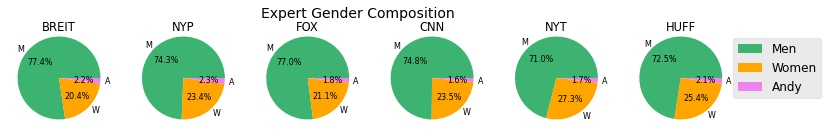

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1616: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


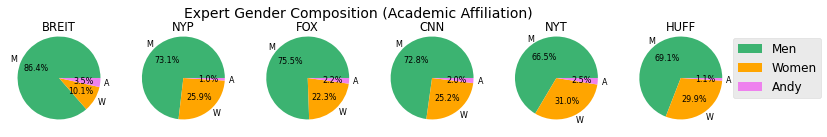

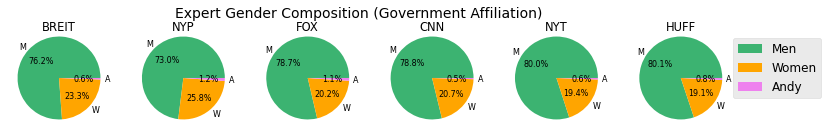

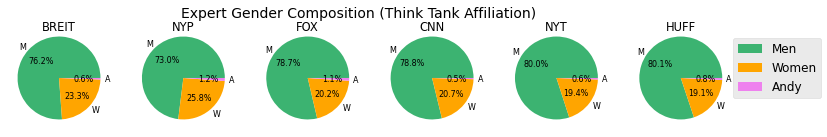

In [495]:
plot_multi_bygender_h(whole_qse,label="Expert Gender Composition")
plot_multi_bygender_h(whole_educ,label="Expert Gender Composition (Academic Affiliation)")
plot_multi_bygender_h(whole_gov,label="Expert Gender Composition (Government Affiliation)")
plot_multi_bygender_h(whole_gov,label="Expert Gender Composition (Think Tank Affiliation)")

Text(0.5, 0.98, 'Gender Composition by Organization Type')

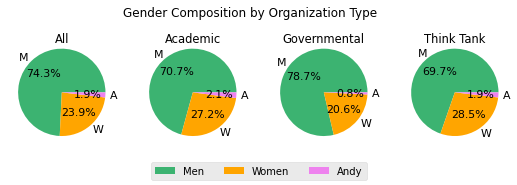

In [406]:
fig, axes = plt.subplots(1,4,figsize=(9,2.5))
label = "dictionary"
title_dict = {0: "All", 1: "Academic", 2:"Governmental", 3:"Think Tank"}
for i, df in enumerate([whole_qse,whole_educ,whole_gov,whole_thinkt]):
    total = df["male_t"].sum() + df["female_t"].sum() + df["andy_t"].sum()
    toplot = [df["male_t"].sum()/total, df["female_t"].sum()/total, df["andy_t"].sum()/total]
    pd.DataFrame(toplot).plot(kind='pie',fontsize=11,labels=["M","W","A"],autopct='%1.1f%%',subplots=True,ax = axes[i],colors=['mediumseagreen','orange','violet'])
    axes[i].get_legend().remove()
    axes[i].set(ylabel='')
    axes[i].set_title(title_dict[i],y=.9)
fig.legend(["Men","Women","Androgenous"],ncol=3,loc=8,fontsize=10)
fig.suptitle("Gender Composition by Organization Type",fontsize = 12)

KeyError: 'male_t'

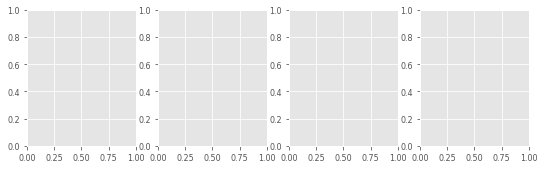

In [551]:
fig, axes = plt.subplots(1,4,figsize=(9,2.5))
label = "dictionary"
title_dict = {0: "All", 1: "Academic", 2:"Governmental", 3:"Think Tank"}
for i, df in enumerate([whole_qse,whole_educ,whole_gov,whole_thinkt]):
    total = df["male_t"].sum() + df["female_t"].sum() + df["andy_t"].sum()
    toplot = [df["male_t"].sum()/total, df["female_t"].sum()/total, df["andy_t"].sum()/total]
    pd.DataFrame(toplot).plot(kind='pie',fontsize=11,labels=["M","W","A"],autopct='%1.1f%%',subplots=True,ax = axes[i],colors=['mediumseagreen','orange','violet'],explode=(0.05, 0.05, 0.05))
    axes[i].get_legend().remove()
    axes[i].set(ylabel='')
    axes[i].set_title(title_dict[i],y=.9)
fig.legend(["Men","Women","Androgenous"],ncol=3,loc=8,fontsize=10)
fig.suptitle("Gender Composition by Organization Type",fontsize = 12)

In [ ]:
plot_total_bygender(whole_educ,"Gender Composition (Academic)")
plot_total_bygender(whole_gov,"Gender Composition (Gov)")
plot_total_bygender(whole_thinkt,"Gender Composition (Think Tank)")

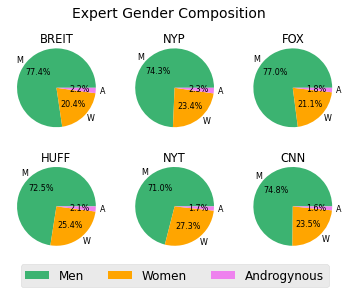

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1616: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


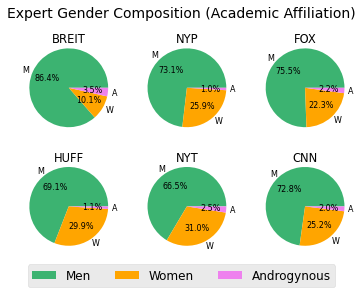

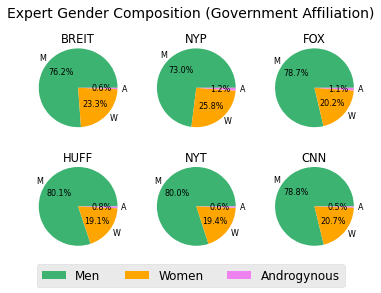

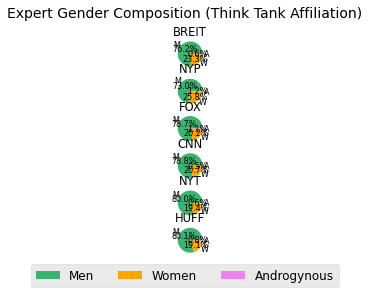

In [334]:
plot_multi_bygender(whole_qse,label="Expert Gender Composition")
plot_multi_bygender(whole_educ,label="Expert Gender Composition (Academic Affiliation)")
plot_multi_bygender(whole_gov,label="Expert Gender Composition (Government Affiliation)")
plot_multi_bygender2(whole_gov,label="Expert Gender Composition (Think Tank Affiliation)")

0.23873524597225812

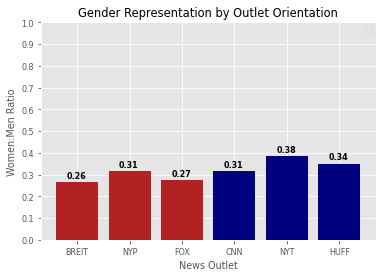

In [492]:
def bar_plot(df, label = "Gender"):
    x = ["BREIT","NYP","FOX","CNN","NYT","HUFF"]
    toplot = pd.DataFrame()
    toplot2 = pd.DataFrame()
    for l in ['BREIT','NYP','FOX','CNN','NYT','HUFF']:
        df_slice = df[df.outlet == l]
        total = df_slice["male_t"].sum() + df_slice["female_t"].sum() + df_slice["andy_t"].sum()
        toplot = toplot.append(pd.DataFrame([[df_slice["male_t"].sum()/total, df_slice["female_t"].sum()/total, df_slice["andy_t"].sum()/total]],columns=["M","W","A"],index=[l]))
        toplot2 = toplot2.append(pd.DataFrame([[df_slice["female_t"].sum()/df_slice["male_t"].sum()]],index = [l],columns=['ratio']))
    #plt.plot(x,toplot.M,label="Men")
    #plt.plot(x,toplot.W,label="Women")
    #plt.plot(x,toplot.A,label="Androgynous")
    plt.bar(x,toplot2.ratio,color=['firebrick','firebrick','firebrick','navy','navy','navy'])
    plt.legend()
    plt.xlabel("News Outlet")
    #plt.xticks(["BREIT","NYP","FOX","CNN","NYT","HUFF"])
    plt.ylabel("Women:Men Ratio")
    plt.yticks(np.arange(0,1.1,.1))
    
    for i, v in enumerate(toplot2.ratio):
        plt.text(i-.2, v + .02, str(v)[:4], color='black', fontweight='bold')

    plt.title("Gender Representation by Outlet Orientation")

bar_plot(whole_qse)

whole_qse['female_t'].sum() / (whole_qse['female_t'].sum() + whole_qse['male_t'].sum() + whole_qse['andy_t'].sum())

Text(0.5, 1.0, 'Expert Gender by News Outlet')

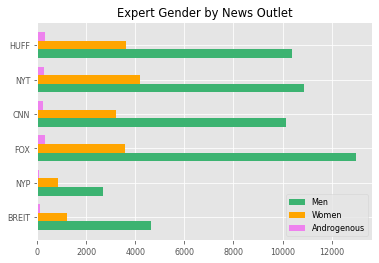

In [452]:
x = ["BREIT","NYP","FOX","CNN","NYT","HUFF"]
toplot = pd.DataFrame()
for l in x:
    df_slice = whole_qse[whole_qse.outlet == l]
    toplot = toplot.append(pd.DataFrame([[df_slice["male_t"].sum(), df_slice["female_t"].sum(), df_slice["andy_t"].sum()]]))
toplot.columns = ['Men','Women','Androgenous']
plt.barh(np.arange(6) - .25,toplot.Men,.25,color='mediumseagreen',label='Men')
plt.barh(np.arange(6),toplot.Women,.25,color='orange',label='Women')
plt.barh(np.arange(6) + .25, toplot.Androgenous,.25, color='violet',label='Androgenous')
plt.yticks(np.arange(6),x)
plt.legend()
plt.title("Expert Gender by News Outlet")

In [467]:
print("Average sentence length: ",whole_thinkt['quote'].str.len().mean())
print("Average sentence length with women: ", whole_thinkt[whole_thinkt["female_t"] > 0]["quote"].str.len().mean())
print("Average sentence length with women: ", whole_thinkt[whole_thinkt["male_t"] > 0]["quote"].str.len().mean())

Average sentence length:  234.08607594936709
Average sentence length with women:  226.47674418604652
Average sentence length with women:  228.40836012861737


reporting_verbs

In [482]:
# 

cols = ['female_t','male_t','andy_t']
df_slice = whole_qse[whole_qse['female_t'] > 0]
print(df_slice.shape[0])
df_slice = df_slice[df_slice['male_t'] > 0]
print(df_slice.shape[0])

16478
605


In [483]:
cols = ['female_t','male_t','andy_t']
df_slice = whole_qse[whole_qse['male_t'] > 0]
print(df_slice.shape[0])
df_slice = df_slice[df_slice['female_t'] > 0]
print(df_slice.shape[0])
#whole_qse[whole_qse['male_t'] > 0]['male_t'].sum()/whole_qse[whole_qse['ale_t'] > 0][cols].sum().sum()

50444
605


In [193]:
# count mentions

times15 = pd.read_csv('timesData-2015rankings.csv')
for i in np.arange(201,402):
    times15.loc[i-1,"world_rank"]= i
times15["c_total"] = 0; times15["c_breit"] = 0; times15["c_nyp"] = 0; times15["c_fox"] = 0;
times15["c_cnn"] = 0; times15["c_nyt"] = 0; times15["c_huff"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ[whole_educ.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        times15.loc[i,"c_"+l.lower()] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total"] = total


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  del sys.path[0]


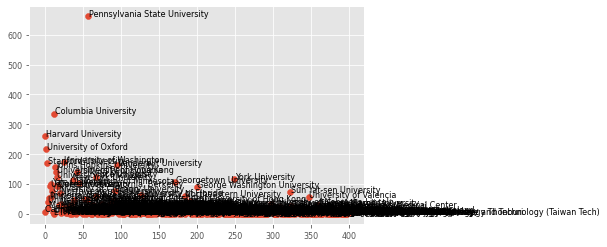

In [199]:
N = 401
fig, ax = plt.subplots()
ax.scatter(times15.index,times15.c_total)
for i, x in times15.iterrows():
    plt.text(x=i+1, y=x.c_total, s=x.university_name)

In [547]:
# Cleaning up PSU
total = 0
whole_educ_clean = whole_educ
for i, x in whole_educ[whole_educ.educ_inst == 'Pennsylvania State University'].iterrows():
    if 'Pennsylvania' not in x.quote:
        whole_educ_clean.drop(index=i, inplace=True)

times15 = pd.read_csv('timesData-2015rankings.csv')
for i in np.arange(201,402):
    times15.loc[i-1,"world_rank"]= i
times15["c_total"] = 0; times15["c_breit"] = 0; times15["c_nyp"] = 0; times15["c_fox"] = 0;
times15["c_cnn"] = 0; times15["c_nyt"] = 0; times15["c_huff"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        times15.loc[i,"c_"+l.lower()] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total"] = total


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


array([[ 1.        , -0.37408574],
       [-0.37408574,  1.        ]])

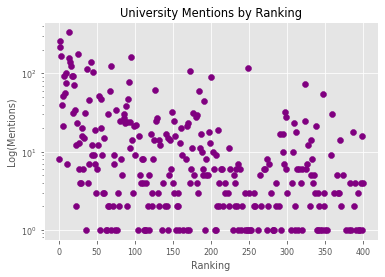

In [550]:
N = 401
fig, ax = plt.subplots()
ax.scatter(times15.index,times15.c_total,color='purple')
#for i, x in times15.iterrows():
    #if i in [13,1,2,95,172,200,249,347,323,92,68,347]:
        #plt.text(x=i+1, y=x.c_total, s=x.university_name)
    #plt.text(x=i+1, y=x.c_total, s=i)
plt.xlabel("Ranking")
plt.ylabel("Log(Mentions)")
plt.title("University Mentions by Ranking")
ax.set_yscale('log')

np.corrcoef(times15.index,times15.c_total)
    #plt.text(x=i,y=x.c_total,s=i)

Text(0.5, 1.0, 'University Mentions by Ranking (Right)')

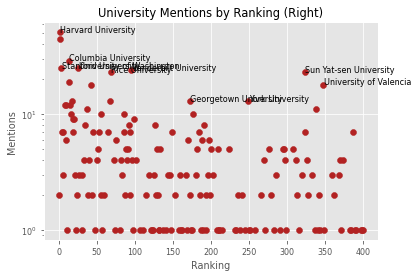

In [542]:
N = 401
fig, ax = plt.subplots()
ax.scatter(times15.index,times15.c_breit + times15.c_nyp + times15.c_fox,color='firebrick')
for i, x in times15.iterrows():
    if i in [1,13,68,3,25,95,172,249,347,323]:
        plt.text(x=i+1, y=x.c_breit + x.c_nyp + x.c_fox, s=x.university_name)
    #plt.text(x=i+1, y=x.c_breit + x.c_nyp + x.c_fox, s=i)
plt.xlabel("Ranking")
plt.ylabel("Mentions")
ax.set_yscale('log')
plt.title("University Mentions by Ranking (Right)")
    #plt.text(x=i,y=x.c_total,s=i)

array([[ 1.        , -0.36773099],
       [-0.36773099,  1.        ]])

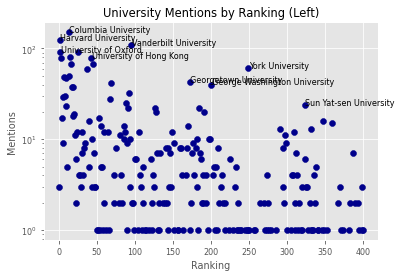

In [543]:
N = 401
fig, ax = plt.subplots()
ax.scatter(times15.index,times15.c_huff + times15.c_nyt + times15.c_cnn,color='darkblue')
for i, x in times15.iterrows():
    if i in [13,1,95,172,200,249,323,2,42]:
        plt.text(x=i+1, y=x.c_huff + x.c_nyt + x.c_cnn, s=x.university_name)
    #plt.text(x=i+1, y=x.c_huff + x.c_nyt + x.c_cnn, s=i)
plt.xlabel("Ranking")
plt.ylabel("Mentions")
ax.set_yscale('log')
plt.title("University Mentions by Ranking (Left)")
    #plt.text(x=i,y=x.c_total,s=i)
np.corrcoef(times15.index,times15.c_huff + times15.c_nyt + times15.c_cnn)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


array([[ 1.        , -0.34967249],
       [-0.34967249,  1.        ]])

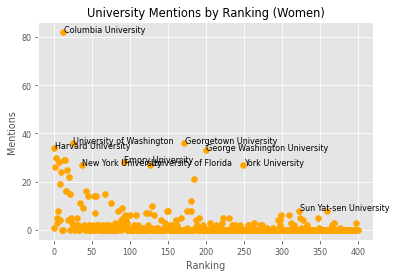

In [327]:
# Ranking of mentions of women
times15 = pd.read_csv('timesData-2015rankings.csv')
for i in np.arange(201,402):
    times15.loc[i-1,"world_rank"]= i
times15["c_total"] = 0; times15["c_breit"] = 0; times15["c_nyp"] = 0; times15["c_fox"] = 0;
times15["c_cnn"] = 0; times15["c_nyt"] = 0; times15["c_huff"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        df_slice = df_slice[df_slice["female_t"] > 0]
        times15.loc[i,"c_"+l.lower()] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total"] = total

N = 401
fig, ax = plt.subplots()
ax.scatter(times15.index,times15.c_huff + times15.c_nyt + times15.c_cnn,color='orange')
for i, x in times15.iterrows():
    if i in [13,1,25,37,92,127,172,200,249,323]:
        plt.text(x=i+1, y=x.c_huff + x.c_nyt + x.c_cnn, s=x.university_name)
    #plt.text(x=i+1, y=x.c_huff + x.c_nyt + x.c_cnn, s=i)
plt.xlabel("Ranking")
plt.ylabel("Mentions")
plt.title("University Mentions by Ranking (Women)")
    #plt.text(x=i,y=x.c_total,s=i)
np.corrcoef(times15.index,times15.c_huff + times15.c_nyt + times15.c_cnn)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


array([[ 1.        , -0.36773099],
       [-0.36773099,  1.        ]])

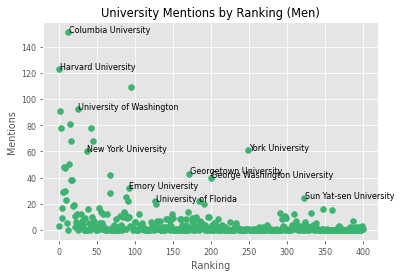

In [328]:
# Ranking of mentions of women
times15 = pd.read_csv('timesData-2015rankings.csv')
for i in np.arange(201,402):
    times15.loc[i-1,"world_rank"]= i
times15["c_total"] = 0; times15["c_breit"] = 0; times15["c_nyp"] = 0; times15["c_fox"] = 0;
times15["c_cnn"] = 0; times15["c_nyt"] = 0; times15["c_huff"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        df_slice = df_slice[df_slice["male_t"] > 0]
        times15.loc[i,"c_"+l.lower()] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total"] = total

N = 401
fig, ax = plt.subplots()
ax.scatter(times15.index,times15.c_huff + times15.c_nyt + times15.c_cnn,color='mediumseagreen')
for i, x in times15.iterrows():
    if i in [13,1,25,37,92,127,172,200,249,323]:
        plt.text(x=i+1, y=x.c_huff + x.c_nyt + x.c_cnn, s=x.university_name)
    #plt.text(x=i+1, y=x.c_huff + x.c_nyt + x.c_cnn, s=i)
plt.xlabel("Ranking")
plt.ylabel("Mentions")
plt.title("University Mentions by Ranking (Men)")
    #plt.text(x=i,y=x.c_total,s=i)
np.corrcoef(times15.index,times15.c_huff + times15.c_nyt + times15.c_cnn)

In [ ]:
def get_unique(df,col):
    past = []
    for idx, row in df.iterrows():
        if isinstance(ast.literal_eval(str(row[col])),list):
            for x in ast.literal_eval(str(row[col])):
                if x not in past:
                    past.append(x)
        else:
            if str(row[col]) not in past:
                past.append(row[col])
    print("Number of unique values for ",col, len(past))

def venn_stats(df,cols):
    print("Total instances: ",df.shape[0])
    for col in cols:
        get_unique(df,col)

print("Stats for yiwen_extr")
yiwen_extr = pd.read_csv("yiwen_extr_consolidated.csv").drop(columns=['Unnamed: 0'])
yiwen_extr.columns = ['people','orgs','source','date','title','quote']
#yiwen_extr.loc[~yiwen_extr['people'].str.contains("\["),"people"] = "['" + yiwen_extr.loc[~yiwen_extr['people'].str.contains("\[")]['people'] + "']"
yiwen_extr.loc[:,"quote"] = yiwen_extr.loc[:,"quote"].str.replace('[','').str.replace(']','')
venn_stats(yiwen_extr,['people','orgs'])

print("Stats for yiwen_educ2")
yiwen_educ2 = pd.read_csv("yiwen_educ2_consolidated.csv").drop(columns=['Unnamed: 0'])
yiwen_educ2 = yiwen_educ2.drop_duplicates(subset=['quote','people'])
yiwen_educ2.loc[:,"quote"] = yiwen_educ2.loc[:,"quote"].str.replace('[','').str.replace(']','')
#yiwen_educ2['educ_inst'] = "'" + yiwen_educ2['educ_inst'].map(str) + "'"
venn_stats(yiwen_educ2,['educ_inst','people'])

print("Stats for yiwen union nyt_qse1")
nyt_union = union_df(nyt_qse_m1,yiwen_extr,['quote'])
venn_stats(nyt_union,['people','orgs'])

print("Stats for yiwen union nyt_educ1")
nyt_educ_m1 = pd.read_csv("nyt_educ_m1.csv")
nyt_educ_m1['educ_inst'] = "'" + nyt_educ_m1['educ_inst'].map(str) + "'"
nyt_union = union_df(nyt_educ_m1,yiwen_educ2,['quote','people','educ_inst'])
venn_stats(nyt_union,['people','educ_inst'])

print("Stats for yiwen intersect nyt_qse1")
nyt_intersect = intersect_df(nyt_qse_m1,yiwen_extr,['quote','people','orgs'])
venn_stats(nyt_intersect,['people','orgs'])

print("Stats for yiwen intersect nyt_educ1")
nyt_intersect = intersect_df(nyt_educ_m1,yiwen_educ2,['quote','people','educ_inst'])
venn_stats(nyt_intersect,['people','educ_inst'])

#nyt_educ_union = union_Df(nyt_educ_m1,)

In [ ]:
nyt_qse = pd.read_csv("nyt_qse.csv")
fox_qse = pd.read_csv("fox_qse_m1.csv")
news_orgs = ['New York Times', 'CNN', 'Fox News', 'Breitbart', 'New York Post', 'Huffington Post']
news_dfs = [nyt_df, cnn_df, fox_df, breit_df, nyp_df, huff_df]
qse_dfs = [nyt_qse, cnn_qse, fox_qse, breit_qse, nyp_qse, huff_qse]
original_instances = [df.shape[0] for df in news_dfs]
qse_instances = [df_qse.shape[0] for df_qse in qse_dfs]

df = pd.DataFrame([original_instances, qse_instances])
df.columns = news_orgs
df.index = ['Original','Processed']
df = df.T
df['News_Org'] = news_orgs
df

x = np.arange(6)
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_instances, width, label='Original Dataset')
rects2 = ax.bar(x + width/2, qse_instances, width, label='Processed Dataset')
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2,padding=3)
ax.set_xticks(x)
ax.set_xticklabels(news_orgs, rotation = 75)
ax.set_title("Dataframe Sizes")
fig.tight_layout()

In [ ]:
news_dfs = [nyt_df, cnn_df, fox_df, breit_df, nyp_df, huff_df]
becca_dfs = [b_nyt_qse, b_cnn_qse, b_fox_qse, b_breit_qse, b_nyp_qse, b_huff_qse]
yiwen_dfs = [y_nyt_qse, y_cnn_qse, y_fox_qse, y_breit_qse, y_nyp_qse, y_huff_qse]
becca_dfs_educ = [b_nyt_educ, b_cnn_educ, b_fox_educ, b_breit_educ, b_nyp_educ, b_huff_educ]
yiwen_dfs_educ = [y_nyt_educ, y_cnn_educ, y_fox_educ, y_breit_educ, y_nyp_educ, y_huff_educ]
comparing_numbers = [[df.shape[0] for df in news_dfs],[df.shape[0] for df in becca_dfs],[df.shape[0] for df in yiwen_dfs],
                    [df.shape[0] for df in becca_dfs_educ], [df.shape[0] for df in yiwen_dfs_educ]]
plotting_numbers = pd.DataFrame(comparing_numbers).T
plotting_numbers.columns = ['articles','dep_extractions','ner_extractions','dep_educ','ner_educ']
plotting_numbers.index = ['NYT','CNN','FOX','BREIT','NYP','HUFF']

n = 3
ind = np.arange(6)
width = 0.2

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width,plotting_numbers.articles,width,color='r')
rects2a = ax.bar(ind,plotting_numbers.dep_extractions,width,color='g')
rects2b = ax.bar(ind,plotting_numbers.ner_extractions,width,bottom=plotting_numbers.dep_extractions,color='y')
rects3 = ax.bar(ind+width,plotting_numbers.dep_educ+plotting_numbers.ner_educ,width,color='b')

ax.set_ylabel("Instances")
ax.set_xticklabels(['NYT','NYT','CNN','FOX','BREIT','NYP','HUFF'])
ax.legend((rects1[0],rects2a[0],rects2b[0],rects3[0]),('original articles','total extractions (dep)','total extractions (ner)','educ-affiliated extractions'))
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, '%d'%int(h),
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2a)
#autolabel(rects2b)
for rect, total in zip(rects2b,plotting_numbers.dep_extractions):
    h = rect.get_height() + total
    ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, '%d'%int(h),
        ha='center', va='bottom')
autolabel(rects3)
ax.set_title("Numbers of Extractions")

plotting_numbers

In [ ]:
news_dfs = [nyt_df, cnn_df, fox_df, breit_df, nyp_df, huff_df]
becca_dfs = [b_nyt_qse, b_cnn_qse, b_fox_qse, b_breit_qse, b_nyp_qse, b_huff_qse]
yiwen_dfs = [y_nyt_qse, y_cnn_qse, y_fox_qse, y_breit_qse, y_nyp_qse, y_huff_qse]
becca_dfs_educ = [b_nyt_educ, b_cnn_educ, b_fox_educ, b_breit_educ, b_nyp_educ, b_huff_educ]
yiwen_dfs_educ = [y_nyt_educ, y_cnn_educ, y_fox_educ, y_breit_educ, y_nyp_educ, y_huff_educ]
comparing_numbers = [[df.shape[0] for df in news_dfs],[df.shape[0] for df in becca_dfs],[df.shape[0] for df in yiwen_dfs],
                    [df.shape[0] for df in becca_dfs_educ], [df.shape[0] for df in yiwen_dfs_educ]]
plotting_numbers = pd.DataFrame(comparing_numbers).T
plotting_numbers.columns = ['articles','dep_extractions','ner_extractions','dep_educ','ner_educ']
plotting_numbers.index = ['NYT','CNN','FOX','BREIT','NYP','HUFF']

n = 4
ind = np.arange(6)
width = 0.2

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2,(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions)/plotting_numbers.articles,width,color='lightpink')
rects2 = ax.bar(ind-width/4,total_univ_y/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='orchid')
rects3 = ax.bar(ind+width/4,total_univ_b/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='gold')
rects4 = ax.bar(ind+width/2,(plotting_numbers.dep_educ + plotting_numbers.ner_educ)/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='skyblue')

ax.set_ylabel("Instances")
ax.set_xticklabels(['NYT','NYT','CNN','FOX','BREIT','NYP','HUFF'])
ax.legend((rects1[0],rects2[0],rects3[0],rects4[0]),('total_extractions/articles','% mentioning university (dep)','% mentioning university (ner)','educ_extractions/total_extractions'))
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        print(h)
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, str(h)[:4] + '%',
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
ax.set_title("Numbers of Extractions")

plotting_numbers

In [ ]:
#plotting_numbers.dep_extractions, plotting_numbers.ner_extractions
fig, axes = plt.subplots(2,3)
pd.DataFrame([plotting_numbers.dep_extractions[0],plotting_numbers.ner_extractions[0]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[0,0])
axes[0,0].get_legend().remove()
axes[0,0].title.set_text('NYT')
pd.DataFrame([plotting_numbers.dep_extractions[1],plotting_numbers.ner_extractions[1]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[0,1])
axes[0,1].get_legend().remove()
axes[0,1].title.set_text('CNN')
pd.DataFrame([plotting_numbers.dep_extractions[2],plotting_numbers.ner_extractions[2]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[0,2])
axes[0,2].get_legend().remove()
axes[0,2].title.set_text('FOX')
pd.DataFrame([plotting_numbers.dep_extractions[3],plotting_numbers.ner_extractions[3]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[1,0])
axes[1,0].get_legend().remove()
axes[1,0].title.set_text('BREIT')
pd.DataFrame([plotting_numbers.dep_extractions[4],plotting_numbers.ner_extractions[4]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[1,1])
axes[1,1].get_legend().remove()
axes[1,1].title.set_text('NYP')
pd.DataFrame([plotting_numbers.dep_extractions[5],plotting_numbers.ner_extractions[5]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[1,2])
axes[1,2].get_legend().remove()
axes[1,2].title.set_text('HUFF')
fig.suptitle("Distribution of Total Extractions")

In [ ]:
n = 3
ind = np.arange(6)
width = 0.2

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2,total_univ_y/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='orchid')
rects2 = ax.bar(ind,total_univ_b/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='gold')
rects3 = ax.bar(ind+width/2,(plotting_numbers.dep_educ + plotting_numbers.ner_educ)/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='skyblue')
ax.set_ylabel("Fraction of Extractions")
ax.set_xticklabels(['NYT','NYT','CNN','FOX','BREIT','NYP','HUFF'])
ax.legend((rects1[0],rects2[0],rects3[0],rects4[0]),('extractions mentioning university (yiwen)','extractions mentioning university (becca)','extractions matching to a university'))
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        print(h)
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, str(h)[:4] ,
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


In [ ]:
total_univ_b = []
total_univ_y = []
for dfb,dfy in zip([b_nyt_qse,b_cnn_qse,b_fox_qse,b_breit_qse,b_nyp_qse,b_huff_qse],[y_nyt_qse,y_cnn_qse,y_fox_qse,y_breit_qse,y_nyp_qse,y_huff_qse]):
    total_univ_b.append(dfb[dfb["quote"].str.contains('University|College|university|college')].shape[0])
    total_univ_y.append(dfy[dfy["quote"].str.contains('University|College|university|college')].shape[0])
print(sum(total_univ_b),sum(total_univ_y))

In [ ]:
# GENDER ANALYSIS
nyt_qse_all = pd.concat([b_nyt_qse,y_nyt_qse])
nyt_qse_all = get_genders(nyt_qse_all)
a, b = plot_total_bygender(nyt_qse_all) # what is a, b?

In [ ]:
# GENDER ANALYSIS
nyt_educ_all = pd.concat([b_nyt_educ,y_nyt_educ])
nyt_educ_all = get_genders(nyt_educ_all)
print("got genders")
a, b = plot_total_bygender(nyt_educ_all) # what is a, b?

In [ ]:
# GENDER ANALYSIS
breit_qse_all = pd.concat([b_breit_qse,y_breit_qse])
breit_qse_all = get_genders(breit_qse_all)
print("got genders")
a, b = plot_total_bygender(breit_qse_all,"Breitbart (Total)") # what is a, b?

breit_educ_all = pd.concat([b_breit_educ,y_breit_educ])
breit_educ_all = get_genders(breit_educ_all)
print("got genders")
a, b = plot_total_bygender(breit_educ_all,"Breitbart Educ (Total)") # what is a, b?

In [ ]:
# GENDER ANALYSIS

cnn_qse_all = pd.concat([b_cnn_qse,y_cnn_qse])
cnn_qse_all["people"] = cnn_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
cnn_qse_all.loc[1620,'people'] = "['Robert Mueller','Donald Trump']"
cnn_qse_all = get_genders(cnn_qse_all)
print("got genders")
a, b = plot_total_bygender(cnn_qse_all,"CNN (Total)") # what is a, b?

cnn_educ_all = pd.concat([b_cnn_educ,y_cnn_educ])
cnn_educ_all["people"] = cnn_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
cnn_educ_all = get_genders(cnn_educ_all)
print("got genders")
a, b = plot_total_bygender(cnn_educ_all,"CNN Educ (Total)") # what is a, b?

In [ ]:
# GENDER ANALYSIS

fox_qse_all = pd.concat([b_fox_qse,y_fox_qse])
fox_qse_all["people"] = fox_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
fox_qse_all = get_genders(fox_qse_all)
print("got genders")
a, b = plot_total_bygender(fox_qse_all,"Fox (Total)") # what is a, b?

fox_educ_all = pd.concat([b_fox_educ,y_fox_educ])
fox_educ_all["people"] = fox_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
fox_educ_all = get_genders(fox_educ_all)
print("got genders")
a, b = plot_total_bygender(fox_educ_all,"Fox Educ (Total)") # what is a, b?

In [ ]:
d = gender.Detector()
g = d.get_gender('Arturo')
g
nyp_qse_all[nyp_qse_all['unknown'] > 0][10:]
"Margaret Huang".split(" ")[0]

In [ ]:
# GENDER ANALYSIS

nyp_qse_all = pd.concat([b_nyp_qse,y_nyp_qse])
nyp_qse_all["people"] = nyp_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
nyp_qse_all.loc[7,'people'] = "[\'Thomas Modly\']"
nyp_qse_all = get_genders(nyp_qse_all)
print("got genders")
a, b = plot_total_bygender(nyp_qse_all,"NYP (Total)") # what is a, b?

nyp_educ_all = pd.concat([b_nyp_educ,y_nyp_educ])
nyp_educ_all["people"] = nyp_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
nyp_educ_all = get_genders(nyp_educ_all)
print("got genders")
a, b = plot_total_bygender(nyp_educ_all,"NYP Educ (Total)") # what is a, b?

In [ ]:
# GENDER ANALYSIS

huff_qse_all = pd.concat([b_huff_qse,y_huff_qse])
huff_qse_all["people"] = huff_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
huff_qse_all.loc[7,'people'] = "[\'Thomas Modly\']"
huff_qse_all = get_genders(huff_qse_all)
print("got genders")
a, b = plot_total_bygender(huff_qse_all,"Huff (Total)") # what is a, b?

huff_educ_all = pd.concat([b_huff_educ,y_huff_educ])
huff_educ_all["people"] = huff_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
huff_educ_all = get_genders(huff_educ_all)
print("got genders")
a, b = plot_total_bygender(huff_educ_all,"Huff Educ (Total)") # what is a, b?

In [ ]:
huff_qse_all = pd.concat([b_huff_qse,y_huff_qse])
huff_qse_all["people"] = huff_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
nyp_qse_all = pd.concat([b_nyp_qse,y_nyp_qse])
nyp_qse_all["people"] = nyp_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
nyp_qse_all.loc[7,'people'] = "[\'Thomas Modly\']"
fox_qse_all = pd.concat([b_fox_qse,y_fox_qse])
fox_qse_all["people"] = fox_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
fox_qse_all.loc[3755,'people'] = "['Joe Biden', 'Jeet Heer']"
fox_qse_all.loc[6044,'people'] = "['Bolton', 'Ayatollahs', 'Khamenei', 'Baier']"
cnn_qse_all = pd.concat([b_cnn_qse,y_cnn_qse])
cnn_qse_all["people"] = cnn_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
cnn_qse_all.loc[1620,'people'] = "['Robert Mueller','Donald Trump']"
breit_qse_all = pd.concat([b_breit_qse,y_breit_qse])
nyt_qse_all = pd.concat([b_nyt_qse,y_nyt_qse])

for df in [nyt_qse_all,cnn_qse_all,huff_qse_all,fox_qse_all,nyp_qse_all,breit_qse_all]:
    df.index = np.arange(df.shape[0])
    df = get_genders(df)

In [ ]:
for df, label in zip([nyt_qse_all,cnn_qse_all,huff_qse_all,fox_qse_all,nyp_qse_all,breit_qse_all],["NYT","CNN","HUFF","FOX","NYP","BREIT"]):
    plot_unique_bygender(df,label,"./genders/unique_qse_"+label+".png") # note that this is actually total

In [ ]:
for df, label in zip([nyt_gov_all, huff_gov_all, cnn_gov_all, fox_gov_all,nyp_gov_all,breit_gov_all],["NYT","HUFF","CNN","FOX","NYP","BREIT"]):
    plot_unique_bygender(df,label,"./genders/unique_gov_"+label+".png")

In [ ]:
breit_qse_all[breit_qse_all.gender.str.contains("unknown")]["people"].value_counts()

In [ ]:
# Government agencies get_genders

huff_gov_all = pd.concat([b_huff_gov, y_huff_gov])
huff_gov_all['people'] = '[\'' + huff_gov_all['people'].str.replace('\[\'','',regex=True).str.replace('\']','',regex=True).str.replace(',','\', \'') + '\']'
huff_gov_all.loc[21,'people'] = "['Anthony Fauci','Mike Pence','Deborah Birx']"
huff_gov_all.loc[24,'people'] = "['Scott Lamb']"
huff_gov_all.loc[203,'people'] = "['Chuck Schumer']"
huff_gov_all.loc[50,'people'] = "['Chuck Schumer']"
huff_gov_all.loc[151,'people'] = "['Michael Flynn']"
huff_gov_all.loc[232,'people'] = "['Ira Forman']"
huff_gov_all.loc[353,'people'] = "['Mitsch Bush']"
huff_gov_all.loc[354,'people'] = "['Mitsch Bush']"
nyp_gov_all = pd.concat([b_nyp_gov,y_nyp_gov])
nyp_gov_all.loc[~nyp_gov_all['people'].str.contains("\["),"people"] = "['" + nyp_gov_all.loc[~nyp_gov_all['people'].str.contains("\["),'people'] + "']"
#nyp_gov_all['people'] = '[\'' + nyp_gov_all['people'].str.replace('\[\'','',regex=True).str.replace('\']','',regex=True).str.replace(',','\', \'').str.replace('\[\"','').str.replace('\"]','').str.replace("\\\\n\'","") + '\']'
nyp_gov_all.loc[22,'people'] = "['Mike Andrews']"
nyp_gov_all.loc[31,'people'] = "['Fox News']"
nyp_gov_all.loc[464,'people'] = "['Gualberto Ruiz']"
nyp_gov_all.loc[75,'people'] = "['Miranda Barbot']"
nyp_gov_all.loc[106,'people'] = "['Corey Johnson']"
nyp_gov_all.loc[170,'people'] = "['Rachel Semmel']"
nyp_gov_all.loc[171,'people'] = "['Julie Gerberding']"
nyp_gov_all.loc[174,'people'] = "['Chen Shih-Chung']"
nyp_gov_all.loc[226,'people'] = "['Michael Strahan']"
nyt_gov_all = pd.concat([b_nyt_gov,y_nyt_gov])
nyt_gov_all['people'] = '[\'' + nyt_gov_all['people'].str.replace('\[\'','',regex=True).str.replace('\']','',regex=True).str.replace(',','\', \'') + '\']'
cnn_gov_all = pd.concat([b_cnn_gov,y_cnn_gov])
cnn_gov_all.loc[~cnn_gov_all['people'].str.contains("\["),"people"] = "['" + cnn_gov_all.loc[~cnn_gov_all['people'].str.contains("\[")]['people'] + "']"
cnn_gov_all['people'] = cnn_gov_all['people'].str.replace("''","'").str.replace("'s","")
cnn_gov_all.loc[648,'people'] = "['Sanders']"
cnn_gov_all.loc[131,'people'] = "['Tonny Fratto','George W. Bush']"
cnn_gov_all.loc[771,'people'] = "['George Bush']"
cnn_gov_all.loc[1380,'people'] = "['Williams']"
cnn_gov_all.loc[1205,'people'] = "['Evers']"
cnn_gov_all.loc[2046,'people'] = "['Evers']"
cnn_gov_all.loc[2066,'people'] = "[\"O'Brien\"]"
cnn_gov_all.loc[2128,'people'] = "['Peter Navarro']"
fox_gov_all = pd.concat([b_fox_gov,y_fox_gov])
fox_gov_all.loc[~fox_gov_all['people'].str.contains("\["),"people"] = "['" + fox_gov_all.loc[~fox_gov_all['people'].str.contains("\[")]['people'] + "']"
fox_gov_all['people'] = fox_gov_all['people'].str.replace("''","'").str.replace("'s","")
fox_gov_all.loc[2002,'people'] = "[\"Daniel O'Day\"]"
breit_gov_all = pd.concat([b_breit_gov,y_breit_gov])
breit_gov_all.loc[~breit_gov_all['people'].str.contains("\["),"people"] = "['" + breit_gov_all.loc[~breit_gov_all['people'].str.contains("\[")]['people'] + "']"

for df in [huff_gov_all,nyp_gov_all,nyt_gov_all,cnn_gov_all,fox_gov_all,breit_gov_all]:
    df.index = np.arange(df.shape[0])
    df = get_genders(df)

for df, label in zip([nyt_gov_all, huff_gov_all, cnn_gov_all, fox_gov_all,nyp_gov_all,breit_gov_all],["NYT","HUFF","CNN","FOX","NYP","BREIT"]):
    plot_unique_bygender(df,label,"./genders/unique_gov_"+label+".png")

In [ ]:
# Government agencies get_genders

huff_thinkt_all = pd.concat([b_huff_thinkt, y_huff_thinkt])
huff_thinkt_all.loc[~huff_thinkt_all['people'].str.contains("\["),"people"] = "['" + huff_thinkt_all.loc[~huff_thinkt_all['people'].str.contains("\[")]['people'] + "']"
nyp_thinkt_all = pd.concat([b_nyp_thinkt,y_nyp_thinkt])
nyp_thinkt_all.loc[~nyp_thinkt_all['people'].str.contains("\["),"people"] = "['" + nyp_thinkt_all.loc[~nyp_thinkt_all['people'].str.contains("\["),'people'] + "']"
#nyp_thinkt_all['people'] = '[\'' + nyp_thinkt_all['people'].str.replace('\[\'','',regex=True).str.replace('\']','',regex=True).str.replace(',','\', \'').str.replace('\[\"','').str.replace('\"]','').str.replace("\\\\n\'","") + '\']'
nyt_thinkt_all = pd.concat([b_nyt_thinkt,y_nyt_thinkt])
nyt_thinkt_all['people'] = '[\'' + nyt_thinkt_all['people'].str.replace('\[\'','',regex=True).str.replace('\']','',regex=True).str.replace(',','\', \'') + '\']'
cnn_thinkt_all = pd.concat([b_cnn_thinkt,y_cnn_thinkt])
cnn_thinkt_all.loc[~cnn_thinkt_all['people'].str.contains("\["),"people"] = "['" + cnn_thinkt_all.loc[~cnn_thinkt_all['people'].str.contains("\[")]['people'] + "']"
cnn_thinkt_all['people'] = cnn_thinkt_all['people'].str.replace("''","'").str.replace("'s","")
fox_thinkt_all = pd.concat([b_fox_thinkt,y_fox_thinkt])
fox_thinkt_all.loc[~fox_thinkt_all['people'].str.contains("\["),"people"] = "['" + fox_thinkt_all.loc[~fox_thinkt_all['people'].str.contains("\[")]['people'] + "']"
fox_thinkt_all['people'] = fox_thinkt_all['people'].str.replace("''","'").str.replace("'s","")
breit_thinkt_all = pd.concat([b_breit_thinkt,y_breit_thinkt])
breit_thinkt_all.loc[~breit_thinkt_all['people'].str.contains("\["),"people"] = "['" + breit_thinkt_all.loc[~breit_thinkt_all['people'].str.contains("\[")]['people'] + "']"

for df in [huff_thinkt_all,nyp_thinkt_all,nyt_thinkt_all,cnn_thinkt_all,fox_thinkt_all,breit_thinkt_all]:
    df.index = np.arange(df.shape[0])
    df = get_genders(df)

for df, label in zip([nyt_thinkt_all, huff_thinkt_all, cnn_thinkt_all, fox_thinkt_all,nyp_thinkt_all,breit_thinkt_all],["NYT","HUFF","CNN","FOX","NYP","BREIT"]):#
    plot_unique_bygender(df,label,"./genders/unique_thinkt_"+label+".png")

In [ ]:
for df, label in zip([nyt_thinkt_all, huff_thinkt_all, cnn_thinkt_all, fox_thinkt_all,nyp_thinkt_all,breit_thinkt_all],["NYT","HUFF","CNN","FOX","NYP","BREIT"]):#
    plot_unique_bygender(df,label,"./genders/unique_thinkt_"+label+".png")

In [ ]:
huff_educ_all = pd.concat([b_huff_educ,y_huff_educ])
huff_educ_all["people"] = huff_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
nyp_educ_all = pd.concat([b_nyp_educ,y_nyp_educ])
nyp_educ_all["people"] = nyp_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
fox_educ_all = pd.concat([b_fox_educ,y_fox_educ])
fox_educ_all["people"] = fox_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
cnn_educ_all = pd.concat([b_cnn_educ,y_cnn_educ])
cnn_educ_all["people"] = cnn_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
breit_educ_all = pd.concat([b_breit_educ,y_breit_educ])
nyt_educ_all = pd.concat([b_nyt_educ,y_nyt_educ])

for df, label in zip([nyt_educ_all,cnn_educ_all,huff_educ_all,fox_educ_all,nyp_educ_all,breit_educ_all],["NYT","CNN","HUFF","FOX","NYP","BREIT"]):
    df = get_genders(df)
    plot_unique_bygender(df,label,"./genders/unique_educ_"+label+".png")

In [ ]:
top_names = pd.DataFrame()
for df in [breit_educ_all,cnn_educ_all,huff_educ_all,fox_educ_all,nyp_educ_all,nyt_educ_all]:
    top_names = top_names.append(df[df.gender.str.contains("unknown")]["people"].value_counts()[:10])
top_names = top_names.T
top_names.columns = ["BREIT","CNN","HUFF","FOX","NYP","NYT"]
top_names  = top_names.replace(np.nan,0)
top_names["sum"] = top_names.apply(np.sum,axis=1)
top_names.sort_values("sum", ascending=False)

In [ ]:
top_names = pd.DataFrame()
for df in [breit_qse_all,cnn_qse_all,huff_qse_all,fox_qse_all,nyp_qse_all,nyt_qse_all]:
    top_names = top_names.append(df[df.gender.str.contains("andy")]["people"].value_counts()[:10])
top_names = top_names.T
top_names.columns = ["BREIT","CNN","HUFF","FOX","NYP","NYT"]
top_names  = top_names.replace(np.nan,0)
top_names["sum"] = top_names.apply(np.sum,axis=1)
top_names.sort_values("sum", ascending=False)

In [ ]:
pd.set_option('max_colwidth', None)
for df in [breit_qse_all,cnn_qse_all,huff_qse_all,fox_qse_all,nyp_qse_all,nyt_qse_all]:
    print(df[df["quote"].str.contains("Hizzoner")].outlet)

In [ ]:
for df, label in zip([fox_educ_all,nyp_educ_all,breit_educ_all],["FOX","NYP","BREIT"]):
    plot_unique_bygender(df,label,"./genders/unique_educ_"+label+".png")

In [ ]:
nyp_gov_all.loc[31,'people'] = "['Fox News']"
nyp_gov_all.loc[226,'people'] = "['Michael Strahan']"
nyp_gov_all[nyp_gov_all['people'].str.contains("Strahan")]
#['Joe'] Biden, Jeet Heer']

In [ ]:

univ_mentions = pd.DataFrame()
univ_nomentions = pd.DataFrame()
for qse,educ in zip([y_nyt_qse,y_cnn_qse,y_fox_qse,y_breit_qse,y_nyp_qse,y_huff_qse],[y_nyt_educ,y_cnn_educ,y_fox_educ,y_breit_educ,y_nyp_educ,y_huff_educ]):
    this_ = qse[qse["quote"].str.contains('University|College|university|college')]#.sample(n=25)
    univ_mentions = univ_mentions.append(this_[this_["idx"].isin(educ.idx)])
    univ_nomentions = univ_nomentions.append(this_[~this_["idx"].isin(educ.idx)])
#univ_mentions

In [ ]:
cnn_qse_all[cnn_qse_all['people'].str.contains('Mueller')]
cnn_qse_all.loc[1620,'people'] = "['Robert Mueller','Donald Trump']"
cnn_qse_all[cnn_qse_all['people'].str.contains('Mueller')]

In [ ]:

univ_mentions = pd.DataFrame()
univ_nomentions = pd.DataFrame()
for qse,educ in zip([b_nyt_qse,b_cnn_qse,b_fox_qse,b_breit_qse,b_nyp_qse,b_huff_qse],[b_nyt_educ,b_cnn_educ,b_fox_educ,b_breit_educ,b_nyp_educ,b_huff_educ]):
    this_ = qse[qse["quote"].str.contains('University|College|university|college')]#.sample(n=25)
    univ_mentions = univ_mentions.append(this_[this_["idx"].isin(educ.idx)])
    univ_nomentions = univ_nomentions.append(this_[~this_["idx"].isin(educ.idx)])
print(univ_mentions.shape, univ_nomentions.shape)

In [ ]:
pd.set_option('max_colwidth', None)
univ_nomentions["orgs"].unique()[20:]
print(univ_mentions.shape, univ_nomentions.shape)

In [ ]:
educs = ['nyt','cnn','fox','breit','nyp']
educs = ['fox','breit','nyp']
nyt_qse = pd.read_csv("nyt_qse.csv")
nyt_qse = nyt_qse.drop(columns = ['Unnamed: 0'])
nyt_qse.columns = ['idx','quote','people','orgs']
cnn_qse = pd.read_csv("cnn_qse.csv")
cnn_qse = cnn_qse.drop(columns = ['Unnamed: 0'])
cnn_qse.columns = ['idx','quote','people','orgs','outlet']
fox_qse = pd.read_csv("fox_qse_m1.csv")
fox_qse.columns = ['index','idx','quote','people','orgs','outlet']
nyp_qse = pd.read_csv("nyp_qse.csv")
nyp_qse = nyp_qse.drop(columns=['Unnamed: 0'])
nyp_qse.columns = ['idx','quote','people','orgs','outlet']
breit_qse = pd.read_csv("breit_qse.csv")
breit_qse = breit_qse.drop(columns=['Unnamed: 0'])
breit_qse.columns = ['idx','quote','people','orgs','outlet']

for df, school in zip([huff_qse],['huff']):
    schools, rest = match_org_test(df,times15.university_name.unique(),90)
    schools.to_csv(str(school)+"_educ.csv")
    gov, rest = match_org_test(rest,gov_ag['0'].unique(),90)
    gov.to_csv(str(school)+"_gov.csv")
    thinkt, rest = match_org_test(rest,thinktanks['tt_name_en'].unique(),90)
    thinkt.to_csv(str(school)+"_thinkt.csv")
    rest.to_csv(str(school)+"_rest.csv")

In [ ]:
for df, school in zip([y_breit_qse],['y_breit']):
    schools, rest = match_org_test(df,times15.university_name.unique(),90)
    schools.to_csv(str(school)+"_educ.csv")
    gov, rest = match_org_test(rest,gov_ag['0'].unique(),90)
    gov.to_csv(str(school)+"_gov.csv")
    thinkt, rest = match_org_test(rest,thinktanks['tt_name_en'].unique(),90)
    thinkt.to_csv(str(school)+"_thinkt.csv")
    rest.to_csv(str(school)+"_rest.csv")

In [ ]:
educs = ['nyt','cnn','fox','breit','nyp']
nyt_qse = pd.read_csv("nyt_qse.csv")
nyt_qse = nyt_qse.drop(columns = ['Unnamed: 0'])
nyt_qse.columns = ['idx','quote','people','orgs']
cnn_qse = pd.read_csv("cnn_qse.csv")
cnn_qse = cnn_qse.drop(columns = ['Unnamed: 0'])
cnn_qse.columns = ['idx','quote','people','orgs','outlet']
fox_qse = pd.read_csv("fox_qse_m1.csv")
nyp_qse = pd.read_csv("nyp_qse.csv")
nyp_qse = nyp_qse.drop(columns=['Unnamed: 0'])
nyp_qse.columns = ['idx','quote','people','orgs','outlet']
breit_qse = pd.read_csv("breit_qse.csv")
breit_qse = breit_qse.drop(columns=['Unnamed: 0'])
breit_qse.columns = ['idx','quote','people','orgs','outlet']

In [ ]:

#fox_qse_m1.columns = ['index', 'quote', 'people', 'orgs', 'source'] # missed_fox
fox_qse_m1.index = fox_qse_m1['index']
fox_educ_m1# = match_org(fox_qse_m1,times15.university_name.unique(),90)

print("Stats for fox qse m1")
fox_qse_m1 = pd.read_csv("fox_qse_m1.csv")
fox_qse_m1 = fox_qse_m1.drop_duplicates(subset=['quote','people','orgs'])
venn_stats(fox_qse_m1,['people','orgs'])

print("Stats for fox educ m1")
fox_educ_m1 = pd.read_csv("fox_educ_m1.csv")
fox_educ_m1['people'] = fox_educ_m1['people'].astype(str)
fox_educ_m1['educ_inst'] = fox_educ_m1['educ_inst'].astype(str)
fox_educ_m1 = fox_educ_m1.drop_duplicates(subset=['quote','people','educ_inst'])
venn_stats(fox_educ_m1,['educ_inst','people'])

In [ ]:
# GET QUOTES IF WE MISSED THEM
def full_from_partial(og_df,df):
    for i, row in df.iterrows():
        og_loc = og_df.loc[row["idx"]]
        sentences = [sent.text for sent in nlp(og_loc["text"]).sents]
        df.loc[i,'quote'] = str([x for x in sentences if row["quote"][1:-1] in x])[1:-1]


In [ ]:
# Takes in a dataframe of "Names", "Count", "Category"
# as well as a dictionary to map categories to category names
def top_experts_bycat(df, cat_name, cat_dict, n):
    for cat in cat_dict.keys():
        df_cat = df[df[cat_name] == cat]
        print(n,"most cited ",cat_dict[cat])
        print(df_cat.nlargest(n,"Count"))

In [ ]:
import seaborn as sns 
def org_chart(df, df_educ, df_gov, df_thinkt, df_rest, label):
    data = [x / df.shape[0] for x in [df_educ.shape[0], df_gov.shape[0], df_thinkt.shape[0], df_rest.shape[0]]]
    labels = ['University','Government','Think Tank','Other']
    colors = sns.color_palette('pastel')
    plt.pie(data,labels=labels,colors=colors,autopct='%.0f%%')
    plt.title(label)
    plt.savefig('./orgs/'+label+'.png')
    plt.show()

huff_educ = pd.read_csv("huff_educ.csv")
huff_gov = pd.read_csv("huff_gov.csv")
huff_thinkt = pd.read_csv("huff_thinkt.csv")
huff_rest = pd.read_csv("huff_rest.csv")
org_chart(huff_qse,huff_educ,huff_gov,huff_thinkt,huff_rest,"HuffingtonPost")
nyt_gov = pd.read_csv("nyt_gov.csv")
nyt_thinkt = pd.read_csv("nyt_thinkt.csv")
nyt_rest = pd.read_csv("nyt_rest.csv")
org_chart(nyt_qse,nyt_educ,nyt_gov,nyt_thinkt,nyt_rest, "NewYorkTimes")
fox_educ = pd.read_csv("fox_educ.csv")
fox_gov = pd.read_csv("fox_gov.csv")
fox_thinkt = pd.read_csv("fox_thinkt.csv")
fox_rest = pd.read_csv("fox_rest.csv")
org_chart(fox_qse,fox_educ,fox_gov,fox_thinkt,fox_rest, "FoxNews")
breit_educ = pd.read_csv("breit_educ.csv")
breit_gov = pd.read_csv("breit_gov.csv")
breit_thinkt = pd.read_csv("breit_thinkt.csv")
breit_rest = pd.read_csv("breit_rest.csv")
org_chart(breit_qse,breit_educ,breit_gov,breit_thinkt,breit_rest, "Breitbart")
cnn_educ = pd.read_csv("cnn_educ.csv")
cnn_gov = pd.read_csv("cnn_gov.csv")
cnn_thinkt = pd.read_csv("cnn_thinkt.csv")
cnn_rest = pd.read_csv("cnn_rest.csv")
org_chart(cnn_qse,cnn_educ,cnn_gov,cnn_thinkt,cnn_rest, "CNN")
nyp_educ = pd.read_csv("nyp_educ.csv")
nyp_gov = pd.read_csv("nyp_gov.csv")
nyp_thinkt = pd.read_csv("nyp_thinkt.csv")
nyp_rest = pd.read_csv("nyp_rest.csv")
org_chart(nyp_qse,nyp_educ,nyp_gov,nyp_thinkt,nyp_rest, "New York Post")

# overall org types
org_chart(whole_qse,whole_educ,whole_gov,whole_thinkt,whole_rest,"Whole")


fox_qse_m1

In [ ]:
# READ IN THE DATA

educs = ['nyt','cnn','fox','breit','nyp','huff']
nyt_qse = pd.read_csv("nyt_qse.csv")
nyt_qse = nyt_qse.drop(columns = ['Unnamed: 0'])
nyt_qse.columns = ['idx','quote','people','orgs']
nyt_qse['outlet'] = 'New York Times'
cnn_qse = pd.read_csv("cnn_qse.csv")
cnn_qse = cnn_qse.drop(columns = ['Unnamed: 0'])
cnn_qse.columns = ['idx','quote','people','orgs','outlet']
fox_qse = pd.read_csv("fox_qse_m1.csv")
fox_qse = fox_qse.drop(columns = ['index.1'])
fox_qse.columns = ['idx','quote','people','orgs','outlet']
nyp_qse = pd.read_csv("nyp_qse.csv")
nyp_qse = nyp_qse.drop(columns=['Unnamed: 0'])
nyp_qse.columns = ['idx','quote','people','orgs','outlet']
breit_qse = pd.read_csv("breit_qse.csv")
breit_qse = breit_qse.drop(columns=['Unnamed: 0'])
breit_qse.columns = ['idx','quote','people','orgs','outlet']
huff_qse = pd.read_csv("huff_qse.csv")
huff_qse = huff_qse.drop(columns = ['Unnamed: 0'])
huff_qse.columns = ['idx','quote','people','orgs','outlet']

huff_educ = pd.read_csv("huff_educ.csv")
huff_gov = pd.read_csv("huff_gov.csv")
huff_thinkt = pd.read_csv("huff_thinkt.csv")
huff_rest = pd.read_csv("huff_rest.csv")

nyt_gov = pd.read_csv("nyt_gov.csv")
nyt_thinkt = pd.read_csv("nyt_thinkt.csv")
nyt_rest = pd.read_csv("nyt_rest.csv")

fox_educ = pd.read_csv("fox_educ.csv")
fox_gov = pd.read_csv("fox_gov.csv")
fox_thinkt = pd.read_csv("fox_thinkt.csv")
fox_rest = pd.read_csv("fox_rest.csv")

breit_educ = pd.read_csv("breit_educ.csv")
breit_gov = pd.read_csv("breit_gov.csv")
breit_thinkt = pd.read_csv("breit_thinkt.csv")
breit_rest = pd.read_csv("breit_rest.csv")

cnn_educ = pd.read_csv("cnn_educ.csv")
cnn_gov = pd.read_csv("cnn_gov.csv")
cnn_thinkt = pd.read_csv("cnn_thinkt.csv")
cnn_rest = pd.read_csv("cnn_rest.csv")

nyp_educ = pd.read_csv("nyp_educ.csv")
nyp_gov = pd.read_csv("nyp_gov.csv")
nyp_thinkt = pd.read_csv("nyp_thinkt.csv")
nyp_rest = pd.read_csv("nyp_rest.csv")

In [ ]:
pd.set_option('max_colwidth', None)
cnn_df.sample(n=1)

In [ ]:
nyt_qse4.columns = ['idx','quote','people','orgs']
nyt_qse4.index = np.arange(0,nyt_qse4.shape[0])
nyt_qse4 = nyt_qse4.astype(str).drop_duplicates(subset=['quote','people','orgs'])
nyt_educ4 = match_org(nyt_qse4, times15["university_name"].unique(), 90)

In [ ]:
nyt_union = nyt_union.drop_duplicates(subset=['quote','people','educ_inst']) #'educ_inst'])
plot_total_bygender(nyt_union)
uniqdf, uniqpast = plot_unique_bygender(nyt_union)


In [ ]:
nyt_educ_m1.columns = ['idx','idx.1','quote','people','educ_inst'] #= match_org(nyt_qse_m1,times15['university_name'].unique(),87)

In [ ]:
nyt_qse_m12 = combine_df(nyt_qse_m1,nyt_qse4)
nyt_educ_m12 = combine_df(nyt_educ_m1,nyt_educ4)

nyt_qse_m12 = nyt_qse_m12.drop_duplicates(subset=['quote','people','orgs'])
nyt_educ_m12 = nyt_educ_m12.drop_duplicates(subset=['quote','educ_inst','people'])

In [ ]:
yiwen_extr#.columns = ['people','orgs','source','date','title','quote']
nyt_qse4
union_nyt_all = combine_df(nyt_qse4, yiwen_extr).drop_duplicates(subset=['quote'])
union_nyt_educ = match_org(union_nyt_all,times15['university_name'].unique(),87)

In [ ]:
gender_dict = {0:"male", 1:"female", 2:"andy", 3:"unknown"}
uniqpast["Count"] = pd.to_numeric(uniqpast["Count"])
top_experts_bycat(uniqpast, "Gender", gender_dict, 10)

In [ ]:
# Bar plot: x axis is academic bins, y axis is counts
for x in np.arange(1,9):
    print("BIN ",x)
    total = uniondf_nyt[uniondf_nyt.bin_rank == x].shape[0]
    print(total)
    for g in ["male", "female", "andy", "unknown"]:
        print(uniondf_nyt[uniondf_nyt.bin_rank == x][g].sum(), uniondf_nyt[uniondf_nyt.bin_rank == x][g].sum()/total)


In [ ]:
yiwen_extr

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.suptitle('Top 15 Most Cited Universities (NYT)')
fig.set_figwidth(10)

uniondf_nyt.educ_inst.value_counts().nlargest(20).plot.bar(x='educ_inst',y='count')
#.nlargest(15,['count']).plot.bar(x='educ_inst',y='count',rot=90,ax=ax1)
#ax.set_xlabel('Academic Institution')
#ax.set_ylabel('Quoted Experts Affiliated')

In [ ]:
# Get bin rankings for the quotes and experts
rankings = [times15[times15.university_name == x].bin_rank for x in uniondf_nyt.educ_inst]
uniondf_nyt["bin_rank"]= [x.values[0] for x in rankings]
uniondf_nyt

In [ ]:
# Form Data Source for Alternative University Names
# https://en.wikipedia.org/wiki/List_of_colloquial_names_for_universities_and_colleges_in_the_United_States
times15 = pd.read_csv('timesData-2015rankings.csv')
becca_educ2 = pd.DataFrame()#columns=['m1_idx','nyt_idx','quote','people','educ_inst'])

none_idx = []
none_org = []
for idx, match in becca_qse.iterrows():
    score = 0
    for t_org in ast.literal_eval(match['orgs']):
        thisorg, thisscore = process.extract(t_org,times15['university_name'].unique(),limit=1)[0]
        if thisscore > score:
            org = thisorg
            score = thisscore
    if score >= 90:
        toappend = [idx, match['idx'], match['quote'], match['people'], org]
        becca_educ2 = becca_educ2.append([toappend])
    else:
        none_idx.append(match['idx'])
        none_org.append(t_org)
becca_educ2.columns = ['m1_idx','nyt_idx','quote','people','educ_inst']
becca_educ2

In [ ]:
# Form Data Source for Alternative University Names
# https://en.wikipedia.org/wiki/List_of_colloquial_names_for_universities_and_colleges_in_the_United_States
times15 = pd.read_csv('timesData-2015rankings.csv')
yiwen_educ2 = pd.DataFrame()#columns=['m1_idx','nyt_idx','quote','people','educ_inst'])

for idx, match in yiwen_extr.iterrows():
    nyt_idx = nyt_data[nyt_data['title'] == match['Title']].index.values
    score = 0
    for t_org in ast.literal_eval(match['Org']):
        thisorg, thisscore = process.extract(t_org,times15['university_name'].unique(),limit=1)[0]
        if thisscore > score:
            org = thisorg
            score = thisscore
    if score >= 90:
        toappend = [idx, nyt_idx, match['Sentence'], match['Name'], org]
        yiwen_educ2 = yiwen_educ2.append([toappend])
yiwen_educ2.columns = ['m1_idx','nyt_idx','quote','people','educ_inst']
yiwen_educ2

In [ ]:
yiwen_educ

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Top 15 Most Cited Universities')
fig.set_figwidth(10)

yiwen_educ.nlargest(15,['count']).plot.bar(x='trad',y='count',rot=90,ax=ax1)
ax1.set_xlabel('Academic Institution')
ax1.set_ylabel('Quoted Experts Affiliated')
ax1.set_title("Method A: NER")

becca_educ.nlargest(15,['count']).plot.bar(x="trad",y="count",rot=90,ax=ax2)
ax2.set_xlabel('Academic Institution')
ax2.set_ylabel('Quoted Experts Affiliated')
ax2.set_title("Method B: Dependency")

In [ ]:
union_nyt_m1all = union_nyt_m1all.drop_duplicates(subset=['quote','orgs','people'])
#union_nyt_m1all = combine_df(nyt_qse_m1, yiwen_extr).drop_duplicates(subset=['quote'])
union_nyt_m1educ = match_org(union_nyt_m1all,times15['university_name'].unique(),87)

#union_nyt_m1all[union_nyt_m1all.duplicated(subset=['quote','people','orgs'])]

and_nyt